# Sentiment Analysis with 4 Methods
This notebook performs sentiment analysis on the `stemmed_text` column using:
1. Score-based labeling (1-2=negative, 3=neutral, 4-5=positive)
2. TextBlob sentiment analysis
3. VADER sentiment analysis
4. Ensemble weighted voting of all three methods

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
# Load the preprocessed data
df = pd.read_csv('google_play_reviews_DigitalBank_preprocessed.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows of stemmed_text:")
print(df[['score', 'stemmed_text']].head(10))


Dataset shape: (10000, 20)

Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'app_id', 'scraped_at', 'review_length', 'word_count', 'tokenized_text', 'filtered_text', 'normalized_text', 'no_stopwords_text', 'stemmed_text']

First few rows of stemmed_text:
   score  \
0      5   
1      5   
2      5   
3      1   
4      3   
5      5   
6      1   
7      1   
8      5   
9      1   

                                                                                          stemmed_text  
0                                                                   sangat mudah guna laku tunggu lama  
1                                                                                               mantap  
2                                                                                         bantu banget  
3                                                                          ganggu t

In [3]:
# Check for missing values in key columns
print("Missing values:")
print(f"Score: {df['score'].isnull().sum()}")
print(f"Stemmed text: {df['stemmed_text'].isnull().sum()}")

# Remove rows with missing stemmed_text
df_clean = df.dropna(subset=['stemmed_text']).copy()
print(f"\nDataset shape after removing missing stemmed_text: {df_clean.shape}")

# Score distribution
print(f"\nScore distribution:")
print(df_clean['score'].value_counts().sort_index())

Missing values:
Score: 0
Stemmed text: 244

Dataset shape after removing missing stemmed_text: (9756, 20)

Score distribution:
score
1    3236
2     526
3     536
4     574
5    4884
Name: count, dtype: int64


## Method 1: Score-based Sentiment Labeling

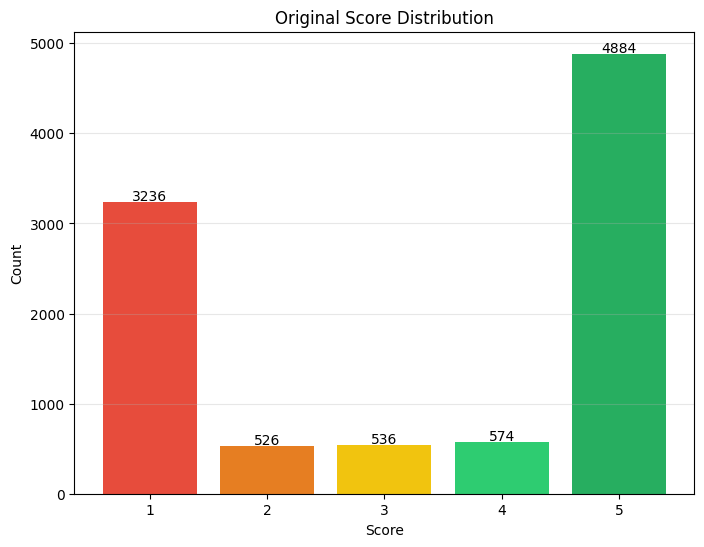

In [4]:
# Visualize the distribution of review scores
plt.figure(figsize=(8, 6))
score_counts = df_clean['score'].value_counts().sort_index()
colors_score = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
plt.bar(score_counts.index, score_counts.values, color=colors_score)
plt.title('Original Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
for i, v in enumerate(score_counts.values):
    plt.text(score_counts.index[i], v + 20, str(v), ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()

Score-based sentiment distribution:
sentiment_score_based
positive    5458
negative    3762
neutral      536
Name: count, dtype: int64


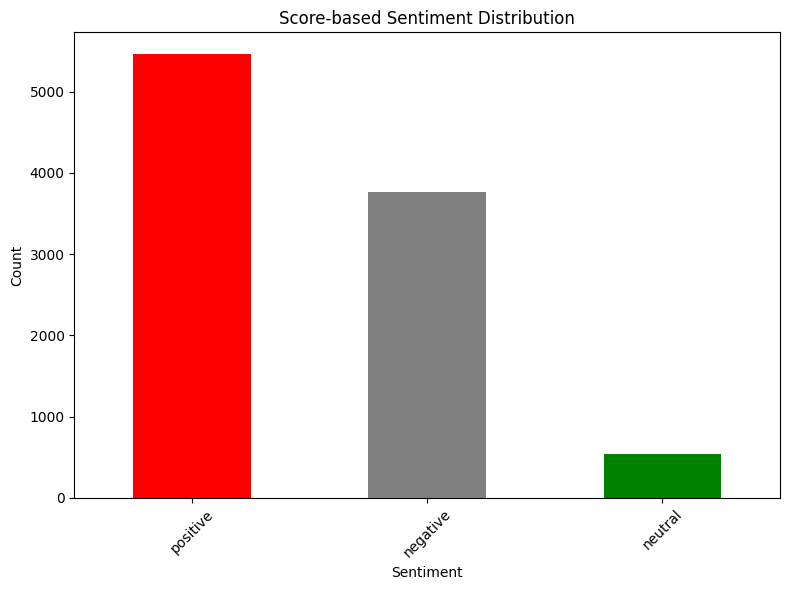

In [5]:
# Method 1: Score-based sentiment labeling
def score_based_sentiment(score):
    """
    Convert score to sentiment label:
    1-2: negative
    3: neutral
    4-5: positive
    """
    if pd.isna(score):
        return 'unknown'
    elif score in [1, 2]:
        return 'negative'
    elif score == 3:
        return 'neutral'
    elif score in [4, 5]:
        return 'positive'
    else:
        return 'unknown'

# Apply score-based sentiment
df_clean['sentiment_score_based'] = df_clean['score'].apply(score_based_sentiment)

print("Score-based sentiment distribution:")
print(df_clean['sentiment_score_based'].value_counts())

# Visualize score-based sentiment distribution
plt.figure(figsize=(8, 6))
df_clean['sentiment_score_based'].value_counts().plot(kind='bar', color=['red', 'gray', 'green', 'orange'])
plt.title('Score-based Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Method 2: TextBlob Sentiment Analysis

In [6]:
# Method 2: TextBlob sentiment analysis
def textblob_sentiment(text):
    """
    Analyze sentiment using TextBlob
    Returns polarity score and sentiment label
    """
    if pd.isna(text) or text.strip() == '':
        return 0.0, 'neutral'
    
    try:
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            sentiment = 'positive'
        elif polarity < -0.1:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'
            
        return polarity, sentiment
    except:
        return 0.0, 'neutral'

# Apply TextBlob sentiment analysis
print("Applying TextBlob sentiment analysis...")
textblob_results = df_clean['stemmed_text'].apply(textblob_sentiment)
df_clean['textblob_polarity'] = [result[0] for result in textblob_results]
df_clean['sentiment_textblob'] = [result[1] for result in textblob_results]

print("\nTextBlob sentiment distribution:")
print(df_clean['sentiment_textblob'].value_counts())

print("\nTextBlob polarity statistics:")
print(df_clean['textblob_polarity'].describe())

Applying TextBlob sentiment analysis...



TextBlob sentiment distribution:
sentiment_textblob
neutral     8871
positive     732
negative     153
Name: count, dtype: int64

TextBlob polarity statistics:
count    9756.000000
mean        0.034567
std         0.168085
min        -0.800000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: textblob_polarity, dtype: float64


## Method 3: VADER Sentiment Analysis

In [7]:
# Method 3: VADER sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    """
    Analyze sentiment using VADER
    Returns compound score and sentiment label
    """
    if pd.isna(text) or text.strip() == '':
        return 0.0, 'neutral'
    
    try:
        scores = analyzer.polarity_scores(str(text))
        compound = scores['compound']
        
        if compound >= 0.05:
            sentiment = 'positive'
        elif compound <= -0.05:
            sentiment = 'negative'
        else:
            sentiment = 'neutral'
            
        return compound, sentiment
    except:
        return 0.0, 'neutral'

# Apply VADER sentiment analysis
print("Applying VADER sentiment analysis...")
vader_results = df_clean['stemmed_text'].apply(vader_sentiment)
df_clean['vader_compound'] = [result[0] for result in vader_results]
df_clean['sentiment_vader'] = [result[1] for result in vader_results]

print("\nVADER sentiment distribution:")
print(df_clean['sentiment_vader'].value_counts())

print("\nVADER compound score statistics:")
print(df_clean['vader_compound'].describe())

Applying VADER sentiment analysis...

VADER sentiment distribution:
sentiment_vader
neutral     8430
positive     999
negative     327
Name: count, dtype: int64

VADER compound score statistics:
count    9756.000000
mean        0.027157
std         0.154125
min        -0.840200
25%         0.000000
50%         0.000000
75%         0.000000
max         0.937100
Name: vader_compound, dtype: float64


## Agreement Analysis Between Methods
Let's analyze how well the different sentiment analysis methods agree with each other.

In [8]:
# Import additional libraries for agreement analysis
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
import itertools
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Function to calculate agreement metrics between two methods
def calculate_agreement_metrics(method1, method2, method1_name, method2_name):
    """
    Calculate various agreement metrics between two sentiment analysis methods
    """
    # Simple agreement (percentage of exact matches)
    simple_agreement = (method1 == method2).mean()
    
    # Cohen's Kappa (accounts for chance agreement)
    kappa = cohen_kappa_score(method1, method2)
    
    # Confusion matrix
    cm = confusion_matrix(method1, method2, labels=['negative', 'neutral', 'positive'])
    
    print(f"\n=== Agreement Analysis: {method1_name} vs {method2_name} ===")
    print(f"Simple Agreement: {simple_agreement:.3f} ({simple_agreement*100:.1f}%)")
    print(f"Cohen's Kappa: {kappa:.3f}")
    
    # Interpret Kappa score
    if kappa < 0:
        kappa_interpretation = "Poor (worse than chance)"
    elif kappa < 0.20:
        kappa_interpretation = "Slight"
    elif kappa < 0.40:
        kappa_interpretation = "Fair"
    elif kappa < 0.60:
        kappa_interpretation = "Moderate"
    elif kappa < 0.80:
        kappa_interpretation = "Substantial"
    else:
        kappa_interpretation = "Almost Perfect"
    
    print(f"Kappa Interpretation: {kappa_interpretation}")
    
    return {
        'simple_agreement': simple_agreement,
        'kappa': kappa,
        'confusion_matrix': cm,
        'kappa_interpretation': kappa_interpretation
    }

In [10]:
# Function to visualize confusion matrix
def plot_confusion_matrix(cm, method1_name, method2_name, labels=['negative', 'neutral', 'positive']):
    """
    Plot confusion matrix for agreement analysis
    """
    plt.figure(figsize=(8, 6))
    
    # Normalize confusion matrix to percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Percentage (%)'})
    
    plt.title(f'Agreement Matrix: {method1_name} vs {method2_name}\n(Row: {method1_name}, Column: {method2_name})')
    plt.xlabel(f'{method2_name} Predictions')
    plt.ylabel(f'{method1_name} Predictions')
    plt.tight_layout()
    plt.show()
    
    # Also show raw counts
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Agreement Matrix (Raw Counts): {method1_name} vs {method2_name}')
    plt.xlabel(f'{method2_name} Predictions')
    plt.ylabel(f'{method1_name} Predictions')
    plt.tight_layout()
    plt.show()


=== Agreement Analysis: Score-based vs TextBlob ===
Simple Agreement: 0.117 (11.7%)
Cohen's Kappa: 0.022
Kappa Interpretation: Slight


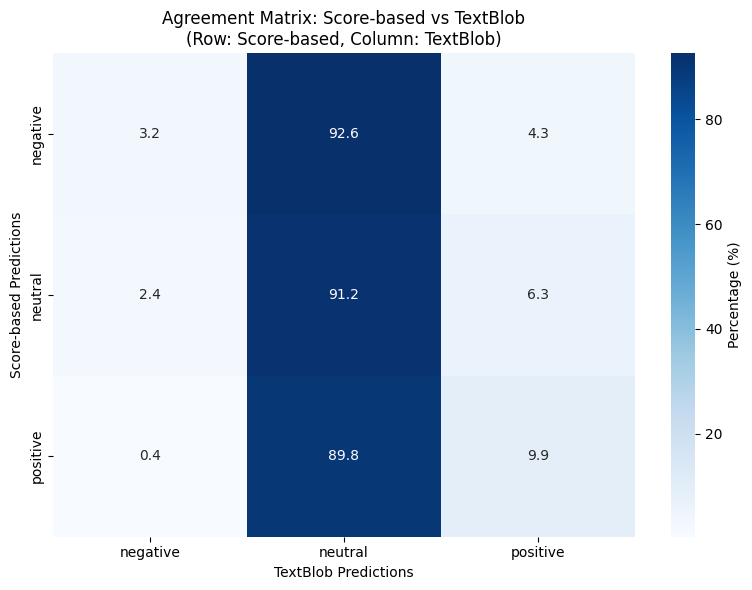

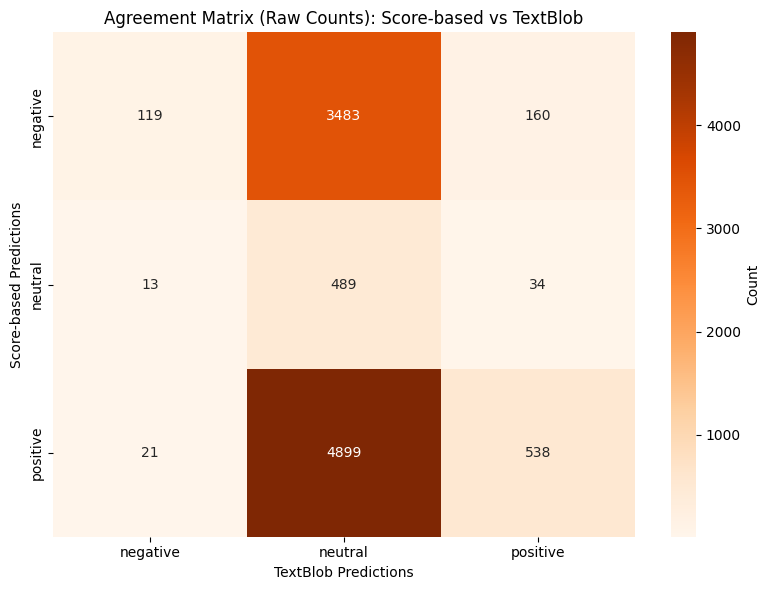


=== Agreement Analysis: Score-based vs VADER ===
Simple Agreement: 0.152 (15.2%)
Cohen's Kappa: 0.039
Kappa Interpretation: Slight


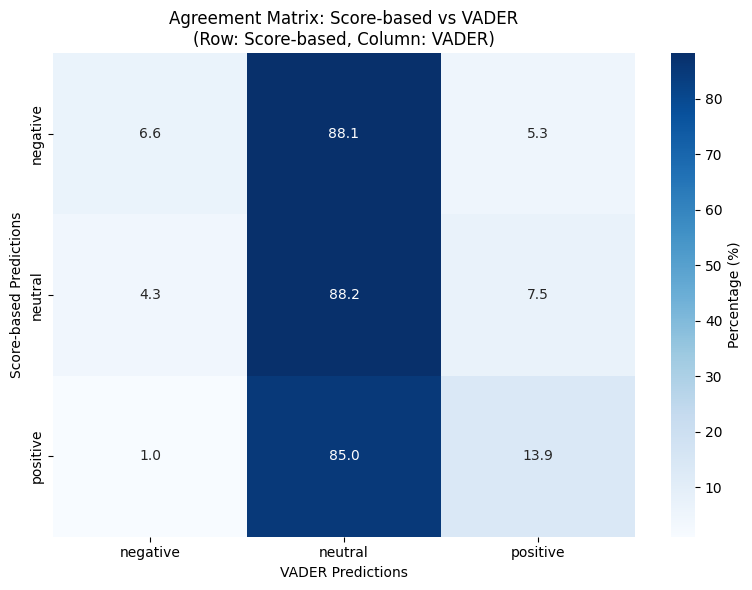

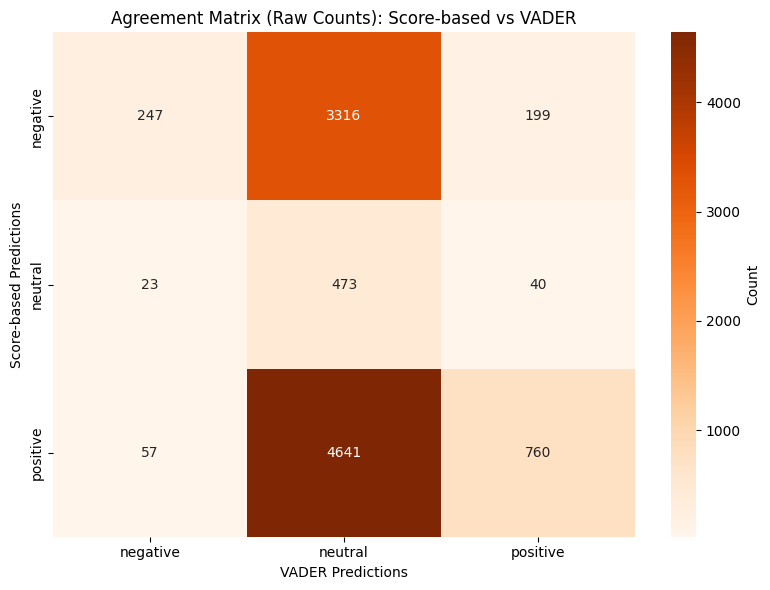


=== Agreement Analysis: TextBlob vs VADER ===
Simple Agreement: 0.927 (92.7%)
Cohen's Kappa: 0.645
Kappa Interpretation: Substantial


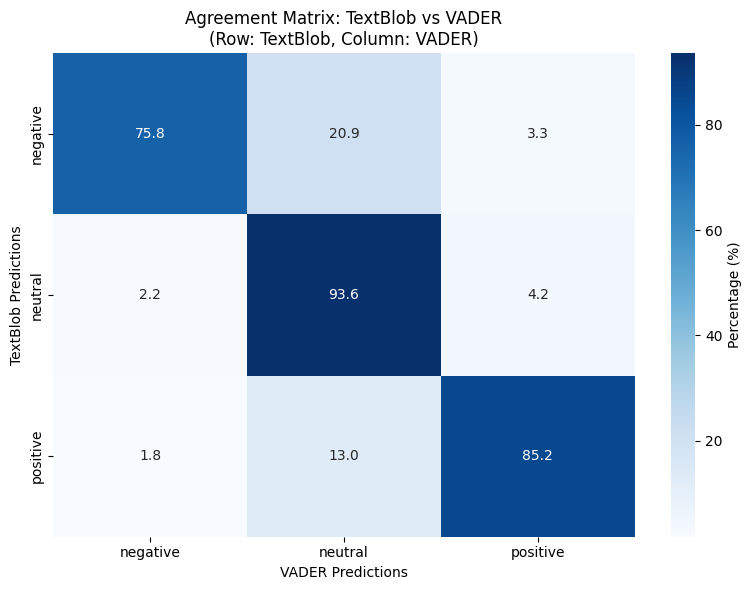

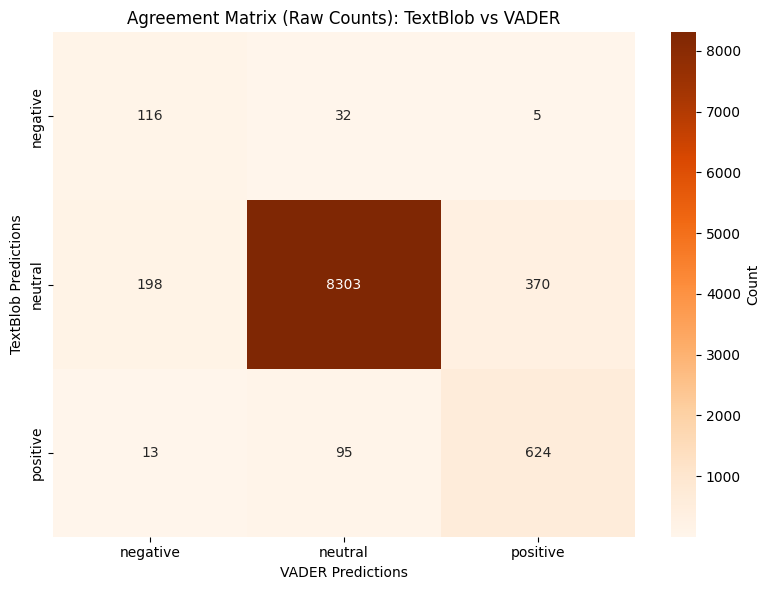

In [11]:
# Pairwise agreement analysis between the three main methods (before ensemble)
methods = {
    'Score-based': df_clean['sentiment_score_based'],
    'TextBlob': df_clean['sentiment_textblob'],
    'VADER': df_clean['sentiment_vader']
}

# Store all agreement results
agreement_results = {}

# Calculate pairwise agreements
method_pairs = list(itertools.combinations(methods.keys(), 2))

for method1_name, method2_name in method_pairs:
    method1_data = methods[method1_name]
    method2_data = methods[method2_name]
    
    # Calculate agreement metrics
    agreement_metrics = calculate_agreement_metrics(
        method1_data, method2_data, method1_name, method2_name
    )
    
    # Store results
    pair_key = f"{method1_name}_vs_{method2_name}"
    agreement_results[pair_key] = agreement_metrics
    
    # Plot confusion matrices
    plot_confusion_matrix(
        agreement_metrics['confusion_matrix'], 
        method1_name, method2_name
    )

## Method 4: Ensemble Weighted Voting

In [12]:
# Method 4: Ensemble weighted voting
def ensemble_sentiment(score_sentiment, textblob_sentiment, vader_sentiment):
    """
    Combine three sentiment methods using weighted voting
    Weights: Score-based=0.4, TextBlob=0.3, VADER=0.3
    """
    # Define weights
    weights = {
        'score_based': 0.4,
        'textblob': 0.3,
        'vader': 0.3
    }
    
    # Count votes for each sentiment
    sentiment_scores = {'positive': 0, 'negative': 0, 'neutral': 0}
    
    # Add weighted votes
    if score_sentiment in sentiment_scores:
        sentiment_scores[score_sentiment] += weights['score_based']
    
    if textblob_sentiment in sentiment_scores:
        sentiment_scores[textblob_sentiment] += weights['textblob']
    
    if vader_sentiment in sentiment_scores:
        sentiment_scores[vader_sentiment] += weights['vader']
    
    # Return sentiment with highest weighted score
    return max(sentiment_scores, key=sentiment_scores.get)

# Apply ensemble sentiment
print("Applying ensemble weighted voting...")
df_clean['sentiment_ensemble'] = df_clean.apply(
    lambda row: ensemble_sentiment(
        row['sentiment_score_based'],
        row['sentiment_textblob'],
        row['sentiment_vader']
    ), axis=1
)

print("\nEnsemble sentiment distribution:")
print(df_clean['sentiment_ensemble'].value_counts())

Applying ensemble weighted voting...

Ensemble sentiment distribution:
sentiment_ensemble
neutral     8355
positive     966
negative     435
Name: count, dtype: int64


## Comprehensive Agreement Analysis
Now that we have all four methods, let's analyze agreement patterns including the ensemble method.


=== Agreement Analysis: Score-based vs Ensemble ===
Simple Agreement: 0.181 (18.1%)
Cohen's Kappa: 0.070
Kappa Interpretation: Slight


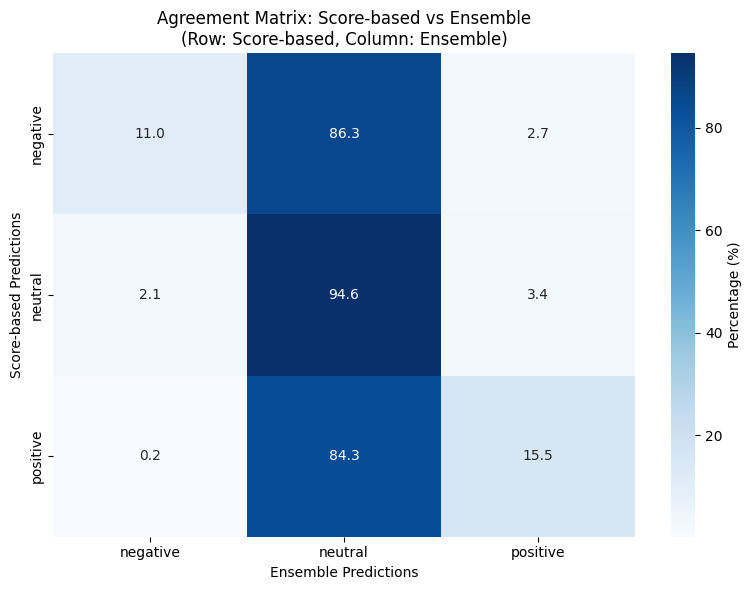

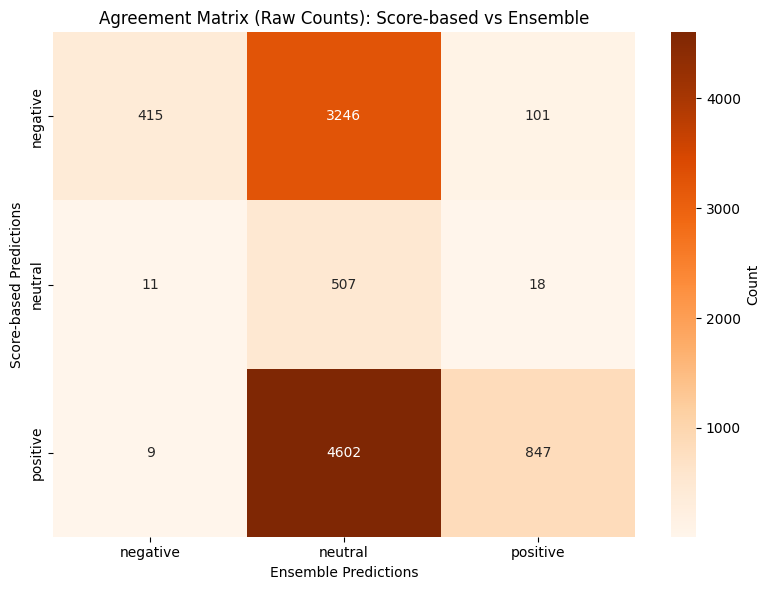


=== Agreement Analysis: TextBlob vs Ensemble ===
Simple Agreement: 0.936 (93.6%)
Cohen's Kappa: 0.700
Kappa Interpretation: Substantial


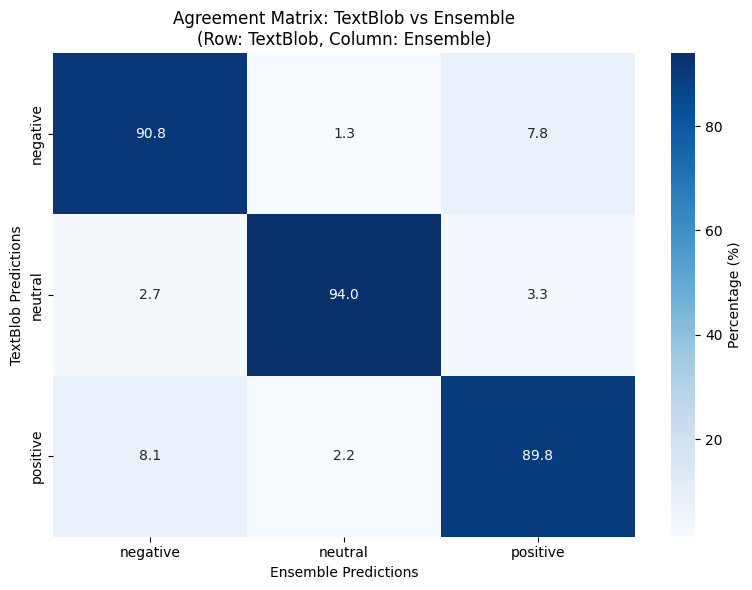

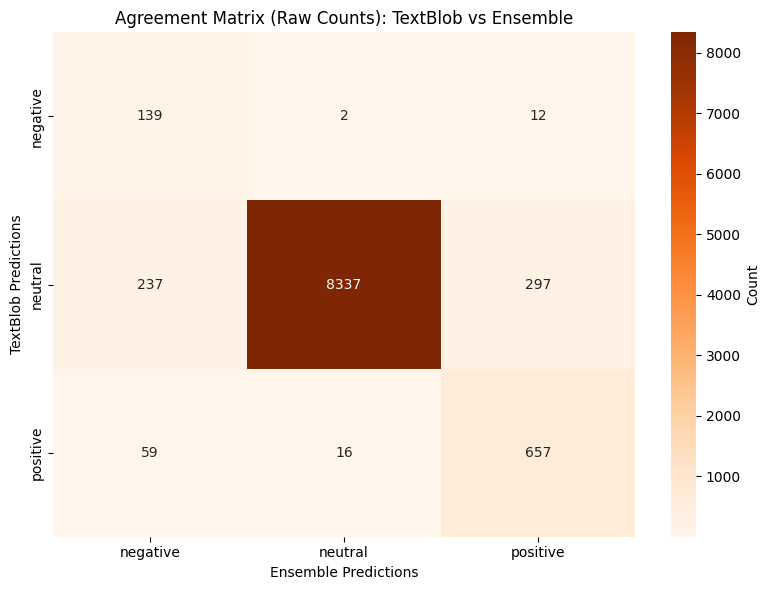


=== Agreement Analysis: VADER vs Ensemble ===
Simple Agreement: 0.970 (97.0%)
Cohen's Kappa: 0.881
Kappa Interpretation: Almost Perfect


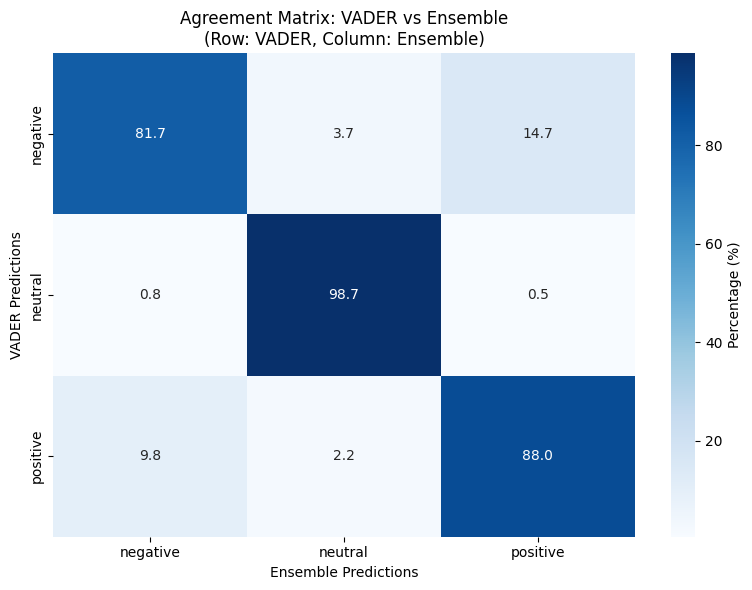

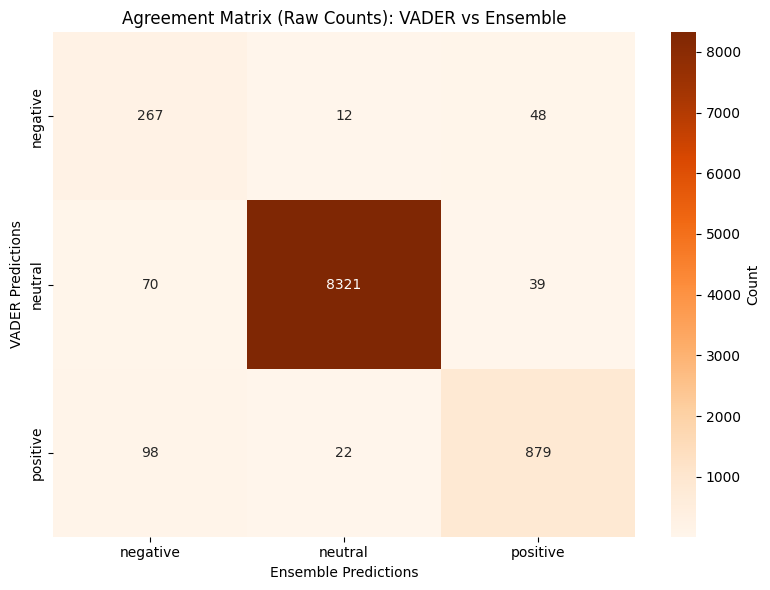

In [13]:
# Update methods dictionary to include ensemble
all_methods = {
    'Score-based': df_clean['sentiment_score_based'],
    'TextBlob': df_clean['sentiment_textblob'],
    'VADER': df_clean['sentiment_vader'],
    'Ensemble': df_clean['sentiment_ensemble']
}

# Calculate pairwise agreements for all methods including ensemble
all_method_pairs = list(itertools.combinations(all_methods.keys(), 2))

# Add ensemble comparisons to existing results
for method1_name, method2_name in all_method_pairs:
    if 'Ensemble' in [method1_name, method2_name]:  # Only calculate new pairs involving ensemble
        method1_data = all_methods[method1_name]
        method2_data = all_methods[method2_name]
        
        # Calculate agreement metrics
        agreement_metrics = calculate_agreement_metrics(
            method1_data, method2_data, method1_name, method2_name
        )
        
        # Store results
        pair_key = f"{method1_name}_vs_{method2_name}"
        agreement_results[pair_key] = agreement_metrics
        
        # Plot confusion matrices
        plot_confusion_matrix(
            agreement_metrics['confusion_matrix'], 
            method1_name, method2_name
        )

In [14]:
# Create comprehensive summary table of all agreement metrics
agreement_summary = []

for pair_key, metrics in agreement_results.items():
    method_pair = pair_key.replace('_vs_', ' vs ')
    agreement_summary.append({
        'Method Pair': method_pair,
        'Simple Agreement': f"{metrics['simple_agreement']:.3f}",
        'Simple Agreement (%)': f"{metrics['simple_agreement']*100:.1f}%",
        'Cohen\'s Kappa': f"{metrics['kappa']:.3f}",
        'Kappa Interpretation': metrics['kappa_interpretation']
    })

agreement_df = pd.DataFrame(agreement_summary)
print("\n=== COMPREHENSIVE AGREEMENT ANALYSIS SUMMARY ===")
print(agreement_df.to_string(index=False))


=== COMPREHENSIVE AGREEMENT ANALYSIS SUMMARY ===
            Method Pair Simple Agreement Simple Agreement (%) Cohen's Kappa Kappa Interpretation
Score-based vs TextBlob            0.117                11.7%         0.022               Slight
   Score-based vs VADER            0.152                15.2%         0.039               Slight
      TextBlob vs VADER            0.927                92.7%         0.645          Substantial
Score-based vs Ensemble            0.181                18.1%         0.070               Slight
   TextBlob vs Ensemble            0.936                93.6%         0.700          Substantial
      VADER vs Ensemble            0.970                97.0%         0.881       Almost Perfect


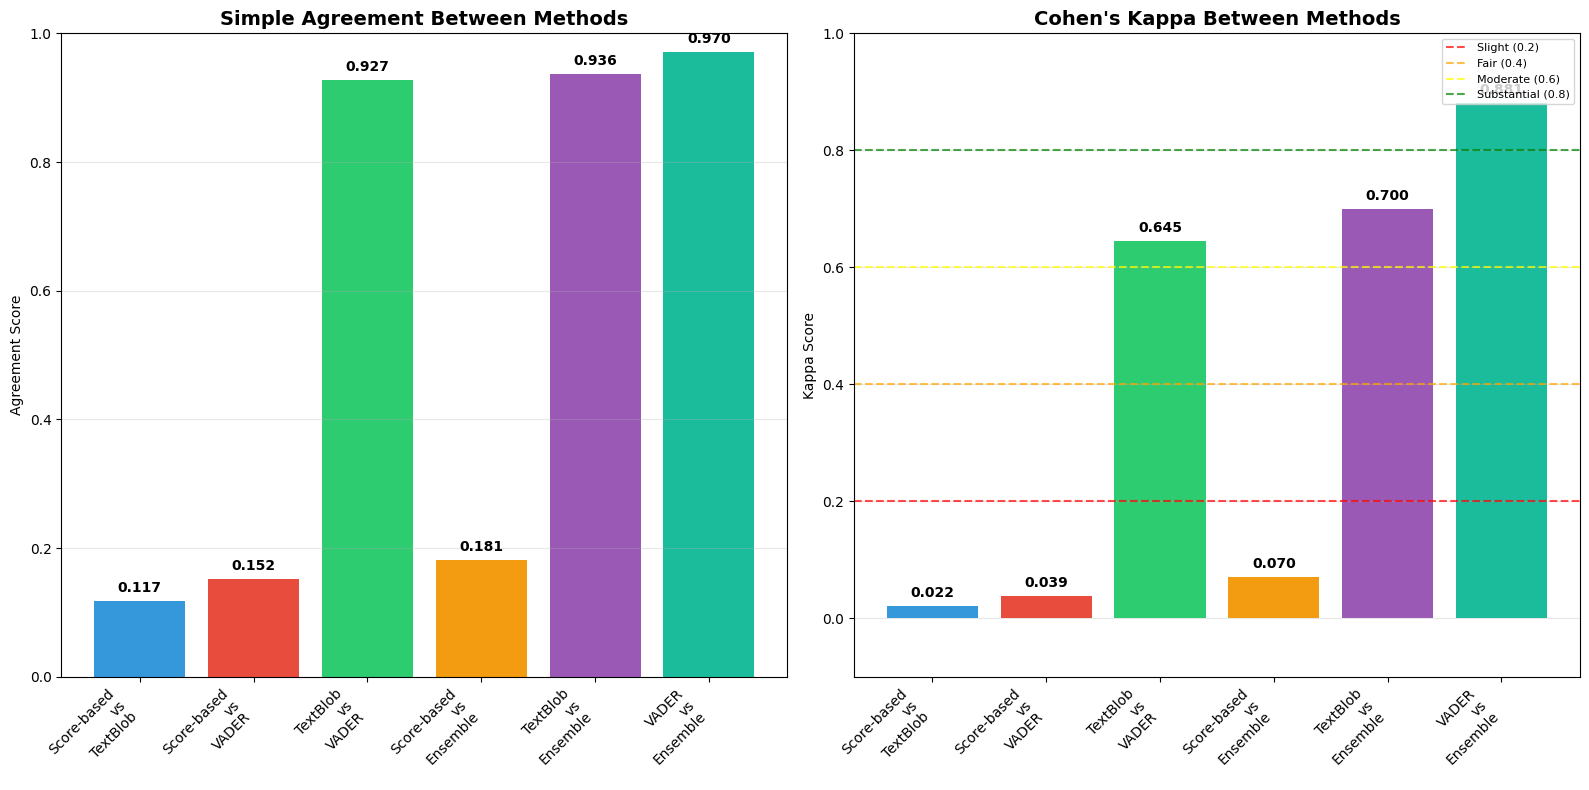

In [15]:
# Visualize agreement scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Simple Agreement scores
method_pairs_labels = [pair.replace('_vs_', '\nvs\n') for pair in agreement_results.keys()]
simple_agreements = [metrics['simple_agreement'] for metrics in agreement_results.values()]
kappa_scores = [metrics['kappa'] for metrics in agreement_results.values()]

# Plot Simple Agreement
colors_agreement = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
bars1 = ax1.bar(range(len(method_pairs_labels)), simple_agreements, 
                color=colors_agreement[:len(method_pairs_labels)])
ax1.set_title('Simple Agreement Between Methods', fontsize=14, fontweight='bold')
ax1.set_ylabel('Agreement Score')
ax1.set_xticks(range(len(method_pairs_labels)))
ax1.set_xticklabels(method_pairs_labels, rotation=45, ha='right')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot Cohen's Kappa
bars2 = ax2.bar(range(len(method_pairs_labels)), kappa_scores,
                color=colors_agreement[:len(method_pairs_labels)])
ax2.set_title('Cohen\'s Kappa Between Methods', fontsize=14, fontweight='bold')
ax2.set_ylabel('Kappa Score')
ax2.set_xticks(range(len(method_pairs_labels)))
ax2.set_xticklabels(method_pairs_labels, rotation=45, ha='right')
ax2.set_ylim(-0.1, 1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Add horizontal lines for Kappa interpretation
ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Slight (0.2)')
ax2.axhline(y=0.4, color='orange', linestyle='--', alpha=0.7, label='Fair (0.4)')
ax2.axhline(y=0.6, color='yellow', linestyle='--', alpha=0.7, label='Moderate (0.6)')
ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Substantial (0.8)')
ax2.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## Detailed Disagreement and Correlation Analysis

In [16]:
# Analyze cases where methods disagree
print("=== DISAGREEMENT ANALYSIS ===")

# 1. Cases where all three original methods disagree
all_disagree = ((df_clean['sentiment_score_based'] != df_clean['sentiment_textblob']) & 
                (df_clean['sentiment_textblob'] != df_clean['sentiment_vader']) & 
                (df_clean['sentiment_score_based'] != df_clean['sentiment_vader']))

print(f"\n1. Cases where all three original methods disagree: {all_disagree.sum()} ({all_disagree.mean()*100:.1f}%)")

# 2. Cases where ensemble differs from majority
# Find cases where 2 methods agree but ensemble chooses differently
score_textblob_agree = (df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & (df_clean['sentiment_ensemble'] != df_clean['sentiment_score_based'])
score_vader_agree = (df_clean['sentiment_score_based'] == df_clean['sentiment_vader']) & (df_clean['sentiment_ensemble'] != df_clean['sentiment_score_based'])
textblob_vader_agree = (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']) & (df_clean['sentiment_ensemble'] != df_clean['sentiment_textblob'])

print(f"\n2. Cases where ensemble differs from majority:")
print(f"   - Score-based & TextBlob agree, but ensemble differs: {score_textblob_agree.sum()}")
print(f"   - Score-based & VADER agree, but ensemble differs: {score_vader_agree.sum()}")
print(f"   - TextBlob & VADER agree, but ensemble differs: {textblob_vader_agree.sum()}")

# 3. Perfect agreement cases
perfect_agreement = ((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
                    (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']) & 
                    (df_clean['sentiment_vader'] == df_clean['sentiment_ensemble']))

print(f"\n3. Perfect agreement (all 4 methods): {perfect_agreement.sum()} ({perfect_agreement.mean()*100:.1f}%)")

=== DISAGREEMENT ANALYSIS ===

1. Cases where all three original methods disagree: 199 (2.0%)

2. Cases where ensemble differs from majority:
   - Score-based & TextBlob agree, but ensemble differs: 0
   - Score-based & VADER agree, but ensemble differs: 0
   - TextBlob & VADER agree, but ensemble differs: 0

3. Perfect agreement (all 4 methods): 1056 (10.8%)



=== CORRELATION ANALYSIS ===

Numerical Score Correlations:
  Score vs TextBlob Polarity: 0.169
  Score vs VADER Compound: 0.180
  TextBlob vs VADER: 0.726


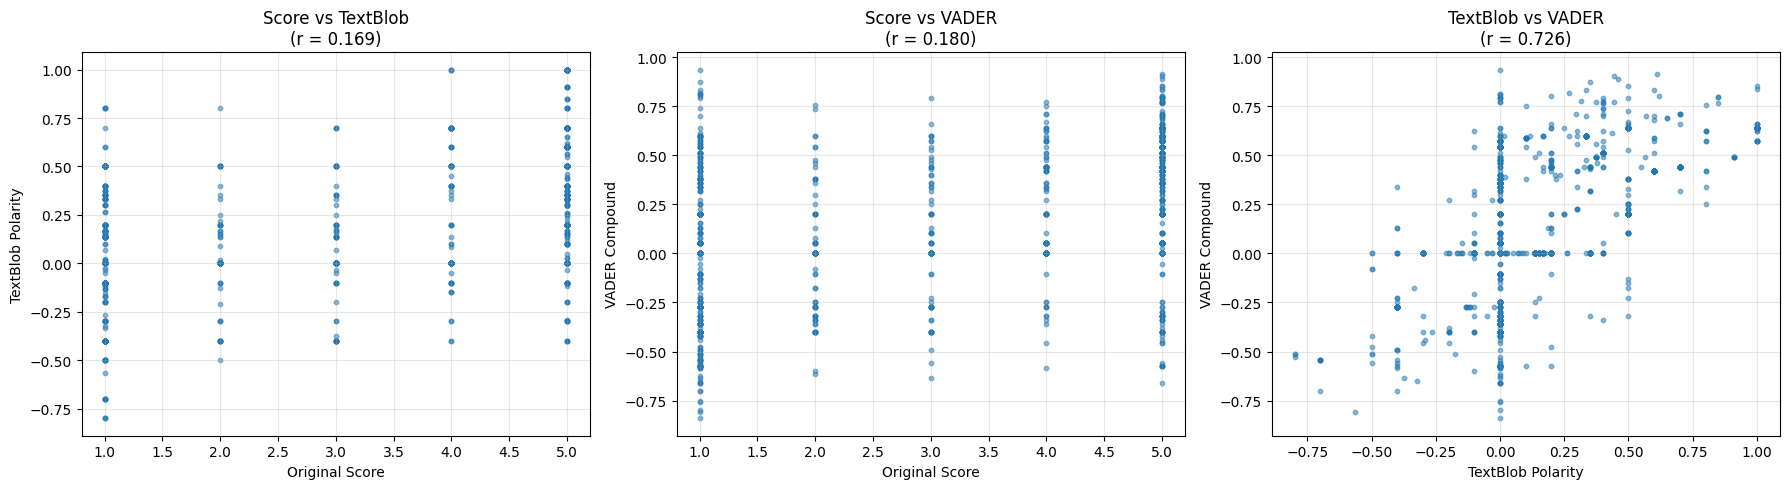

In [17]:
# Correlation analysis between numerical scores
print("\n=== CORRELATION ANALYSIS ===")

# Calculate correlations between numerical scores
correlations = {
    'Score vs TextBlob Polarity': df_clean['score'].corr(df_clean['textblob_polarity']),
    'Score vs VADER Compound': df_clean['score'].corr(df_clean['vader_compound']),
    'TextBlob vs VADER': df_clean['textblob_polarity'].corr(df_clean['vader_compound'])
}

print("\nNumerical Score Correlations:")
for pair, corr in correlations.items():
    print(f"  {pair}: {corr:.3f}")

# Visualize correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score vs TextBlob
axes[0].scatter(df_clean['score'], df_clean['textblob_polarity'], alpha=0.5, s=10)
axes[0].set_xlabel('Original Score')
axes[0].set_ylabel('TextBlob Polarity')
axes[0].set_title(f'Score vs TextBlob\n(r = {correlations["Score vs TextBlob Polarity"]:.3f})')
axes[0].grid(True, alpha=0.3)

# Score vs VADER
axes[1].scatter(df_clean['score'], df_clean['vader_compound'], alpha=0.5, s=10)
axes[1].set_xlabel('Original Score')
axes[1].set_ylabel('VADER Compound')
axes[1].set_title(f'Score vs VADER\n(r = {correlations["Score vs VADER Compound"]:.3f})')
axes[1].grid(True, alpha=0.3)

# TextBlob vs VADER
axes[2].scatter(df_clean['textblob_polarity'], df_clean['vader_compound'], alpha=0.5, s=10)
axes[2].set_xlabel('TextBlob Polarity')
axes[2].set_ylabel('VADER Compound')
axes[2].set_title(f'TextBlob vs VADER\n(r = {correlations["TextBlob vs VADER"]:.3f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== AGREEMENT HEATMAP ===


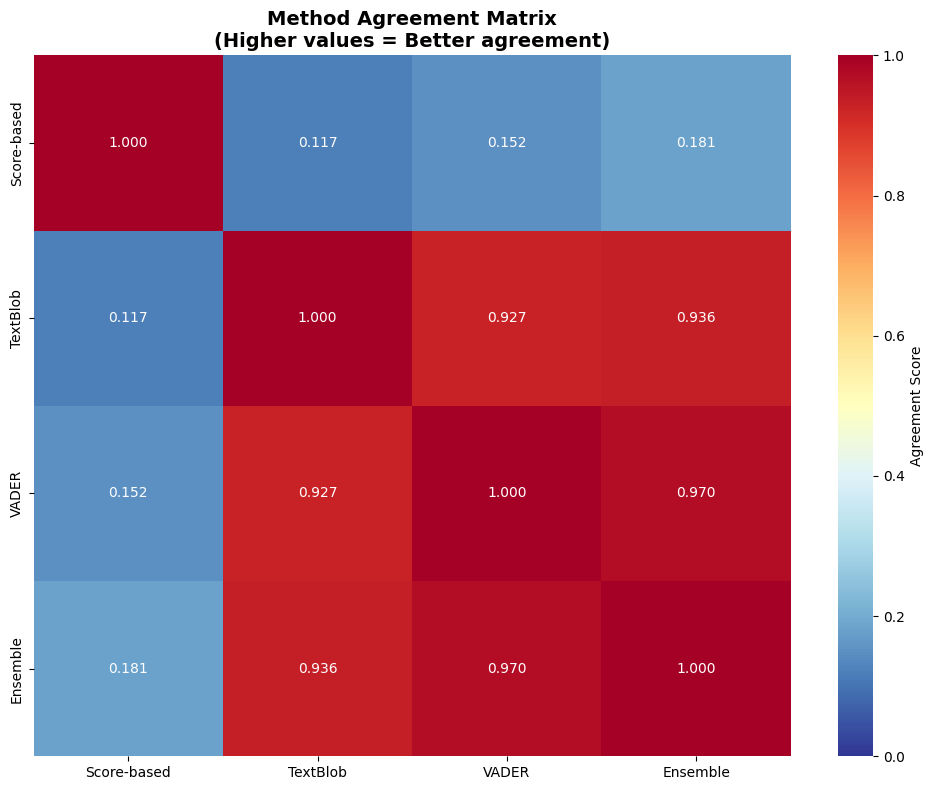


Agreement Matrix:
             Score-based  TextBlob  VADER  Ensemble
Score-based        1.000     0.117  0.152     0.181
TextBlob           0.117     1.000  0.927     0.936
VADER              0.152     0.927  1.000     0.970
Ensemble           0.181     0.936  0.970     1.000


In [18]:
# Agreement heatmap matrix
print("\n=== AGREEMENT HEATMAP ===")

# Create agreement matrix
method_names = ['Score-based', 'TextBlob', 'VADER', 'Ensemble']
method_columns = ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']

agreement_matrix = np.zeros((4, 4))
for i, col1 in enumerate(method_columns):
    for j, col2 in enumerate(method_columns):
        if i == j:
            agreement_matrix[i, j] = 1.0  # Perfect agreement with itself
        else:
            agreement_matrix[i, j] = (df_clean[col1] == df_clean[col2]).mean()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            xticklabels=method_names, yticklabels=method_names,
            vmin=0, vmax=1, cbar_kws={'label': 'Agreement Score'})
plt.title('Method Agreement Matrix\n(Higher values = Better agreement)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print the matrix values
print("\nAgreement Matrix:")
agreement_df_matrix = pd.DataFrame(agreement_matrix, 
                                  index=method_names, 
                                  columns=method_names)
print(agreement_df_matrix.round(3))

## Agreement Analysis Insights and Recommendations

In [19]:
# Generate insights based on agreement analysis
print("=== AGREEMENT ANALYSIS INSIGHTS ===")

# Find best and worst agreeing method pairs
agreement_scores = {}
for pair_key, metrics in agreement_results.items():
    agreement_scores[pair_key] = metrics['simple_agreement']

best_agreement = max(agreement_scores.items(), key=lambda x: x[1])
worst_agreement = min(agreement_scores.items(), key=lambda x: x[1])

print(f"\n1. BEST AGREEMENT:")
print(f"   {best_agreement[0].replace('_vs_', ' vs ')}: {best_agreement[1]:.3f} ({best_agreement[1]*100:.1f}%)")
print(f"   Kappa: {agreement_results[best_agreement[0]]['kappa']:.3f} ({agreement_results[best_agreement[0]]['kappa_interpretation']})")

print(f"\n2. WORST AGREEMENT:")
print(f"   {worst_agreement[0].replace('_vs_', ' vs ')}: {worst_agreement[1]:.3f} ({worst_agreement[1]*100:.1f}%)")
print(f"   Kappa: {agreement_results[worst_agreement[0]]['kappa']:.3f} ({agreement_results[worst_agreement[0]]['kappa_interpretation']})")

# Ensemble performance analysis
ensemble_agreements = {k: v for k, v in agreement_scores.items() if 'Ensemble' in k}
print(f"\n3. ENSEMBLE PERFORMANCE:")
for pair, score in ensemble_agreements.items():
    method_name = pair.replace('_vs_Ensemble', '').replace('Ensemble_vs_', '')
    print(f"   Agreement with {method_name}: {score:.3f} ({score*100:.1f}%)")

# Calculate average ensemble agreement
avg_ensemble_agreement = np.mean(list(ensemble_agreements.values()))
print(f"   Average ensemble agreement: {avg_ensemble_agreement:.3f} ({avg_ensemble_agreement*100:.1f}%)")

# Method reliability assessment
print(f"\n4. METHOD RELIABILITY ASSESSMENT:")
method_reliability = {}
for method in ['Score-based', 'TextBlob', 'VADER']:
    # Calculate average agreement with other methods
    agreements = []
    for pair_key, score in agreement_scores.items():
        if method in pair_key and 'Ensemble' not in pair_key:
            agreements.append(score)
    
    if agreements:
        avg_agreement = np.mean(agreements)
        method_reliability[method] = avg_agreement
        print(f"   {method}: {avg_agreement:.3f} ({avg_agreement*100:.1f}%) average agreement")

# Recommendations
print(f"\n5. RECOMMENDATIONS:")
most_reliable = max(method_reliability.items(), key=lambda x: x[1])
least_reliable = min(method_reliability.items(), key=lambda x: x[1])

print(f"   • Most reliable method: {most_reliable[0]} (avg agreement: {most_reliable[1]:.3f})")
print(f"   • Least reliable method: {least_reliable[0]} (avg agreement: {least_reliable[1]:.3f})")
print(f"   • Ensemble method shows {avg_ensemble_agreement:.1%} average agreement with individual methods")

if avg_ensemble_agreement > max(method_reliability.values()):
    print(f"   • ✓ Ensemble method outperforms individual methods in consistency")
else:
    print(f"   • ⚠ Ensemble method may need weight adjustment")

# Correlation insights
print(f"\n6. CORRELATION INSIGHTS:")
for pair, corr in correlations.items():
    if abs(corr) > 0.5:
        print(f"   • Strong correlation: {pair} (r = {corr:.3f})")
    elif abs(corr) > 0.3:
        print(f"   • Moderate correlation: {pair} (r = {corr:.3f})")
    else:
        print(f"   • Weak correlation: {pair} (r = {corr:.3f})")

=== AGREEMENT ANALYSIS INSIGHTS ===

1. BEST AGREEMENT:
   VADER vs Ensemble: 0.970 (97.0%)
   Kappa: 0.881 (Almost Perfect)

2. WORST AGREEMENT:
   Score-based vs TextBlob: 0.117 (11.7%)
   Kappa: 0.022 (Slight)

3. ENSEMBLE PERFORMANCE:
   Agreement with Score-based: 0.181 (18.1%)
   Agreement with TextBlob: 0.936 (93.6%)
   Agreement with VADER: 0.970 (97.0%)
   Average ensemble agreement: 0.696 (69.6%)

4. METHOD RELIABILITY ASSESSMENT:
   Score-based: 0.135 (13.5%) average agreement
   TextBlob: 0.522 (52.2%) average agreement
   VADER: 0.539 (53.9%) average agreement

5. RECOMMENDATIONS:
   • Most reliable method: VADER (avg agreement: 0.539)
   • Least reliable method: Score-based (avg agreement: 0.135)
   • Ensemble method shows 69.6% average agreement with individual methods
   • ✓ Ensemble method outperforms individual methods in consistency

6. CORRELATION INSIGHTS:
   • Weak correlation: Score vs TextBlob Polarity (r = 0.169)
   • Weak correlation: Score vs VADER Compound (

## Comparison and Analysis

Sentiment distribution comparison:
                       sentiment_score_based  sentiment_textblob  \
sentiment_score_based                                              
positive                                5458                 732   
negative                                3762                 153   
neutral                                  536                8871   

                       sentiment_vader  sentiment_ensemble  
sentiment_score_based                                       
positive                           999                 966  
negative                           327                 435  
neutral                           8430                8355  


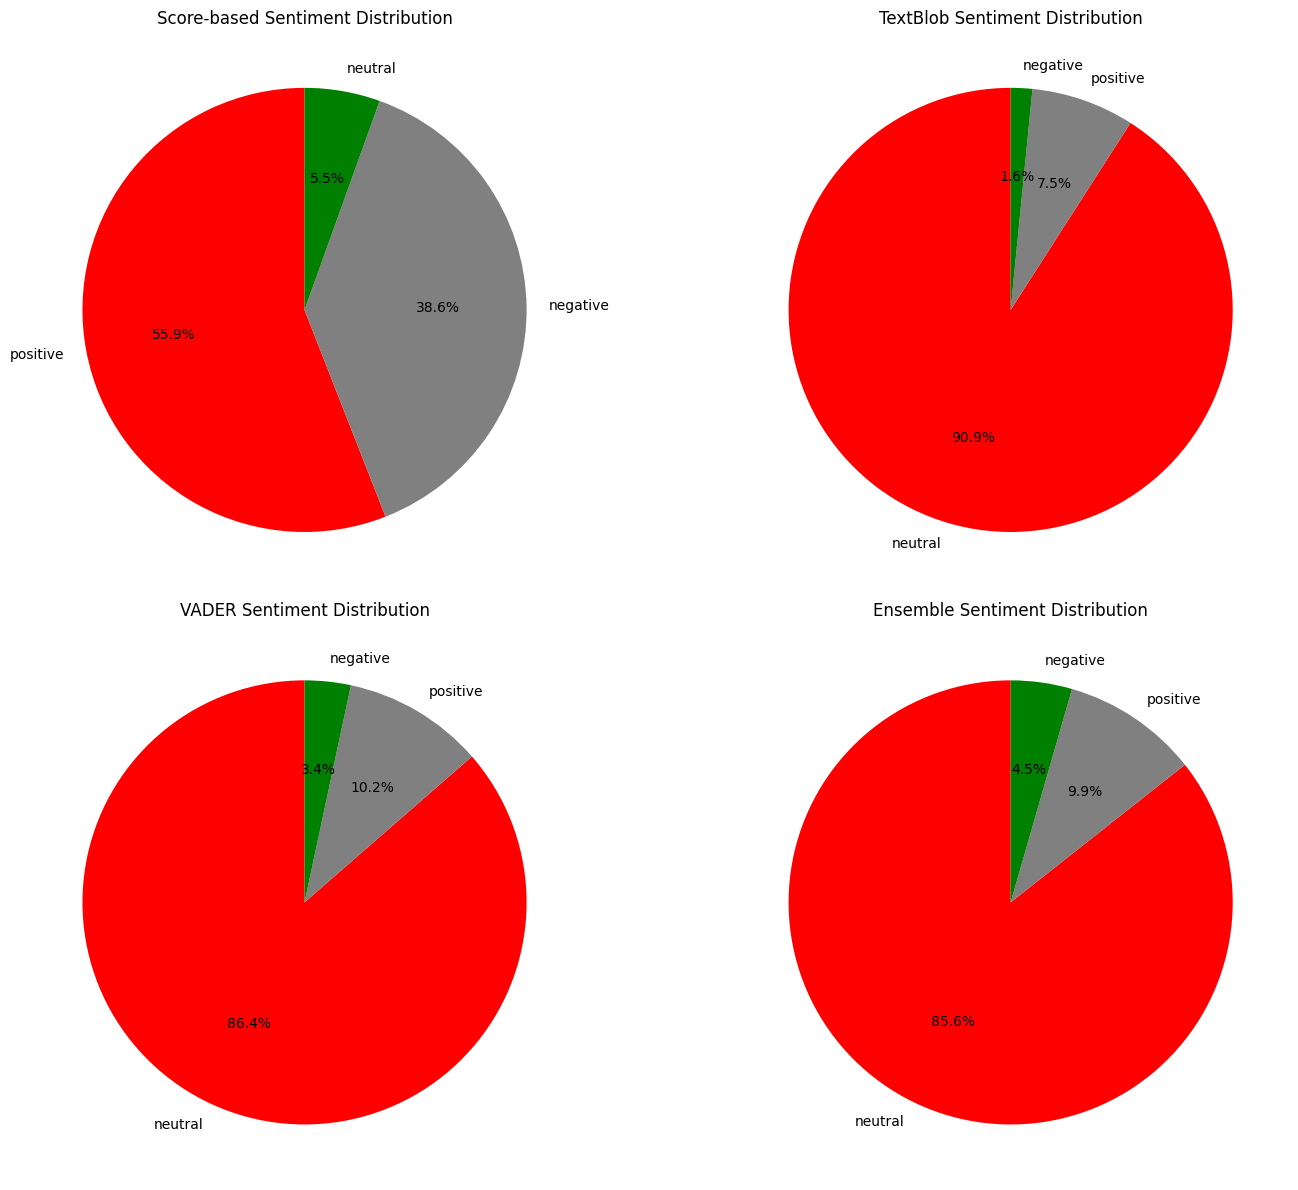

In [20]:
# Compare all sentiment methods
sentiment_columns = ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']

print("Sentiment distribution comparison:")
comparison_df = pd.DataFrame()
for col in sentiment_columns:
    comparison_df[col] = df_clean[col].value_counts()

comparison_df = comparison_df.fillna(0).astype(int)
print(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

colors = ['red', 'gray', 'green']
method_names = ['Score-based', 'TextBlob', 'VADER', 'Ensemble']

for i, col in enumerate(sentiment_columns):
    sentiment_counts = df_clean[col].value_counts()
    axes[i].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                colors=colors[:len(sentiment_counts)], startangle=90)
    axes[i].set_title(f'{method_names[i]} Sentiment Distribution')

plt.tight_layout()
plt.show()

In [21]:
# Agreement analysis between methods
print("Agreement analysis between sentiment methods:")
print("\n1. Score-based vs TextBlob:")
agreement_1 = (df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']).mean()
print(f"Agreement: {agreement_1:.3f} ({agreement_1*100:.1f}%)")

print("\n2. Score-based vs VADER:")
agreement_2 = (df_clean['sentiment_score_based'] == df_clean['sentiment_vader']).mean()
print(f"Agreement: {agreement_2:.3f} ({agreement_2*100:.1f}%)")

print("\n3. TextBlob vs VADER:")
agreement_3 = (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']).mean()
print(f"Agreement: {agreement_3:.3f} ({agreement_3*100:.1f}%)")

print("\n4. All three methods agree:")
all_agree = ((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
             (df_clean['sentiment_textblob'] == df_clean['sentiment_vader'])).mean()
print(f"Agreement: {all_agree:.3f} ({all_agree*100:.1f}%)")

Agreement analysis between sentiment methods:

1. Score-based vs TextBlob:
Agreement: 0.117 (11.7%)

2. Score-based vs VADER:
Agreement: 0.152 (15.2%)

3. TextBlob vs VADER:
Agreement: 0.927 (92.7%)

4. All three methods agree:
Agreement: 0.108 (10.8%)


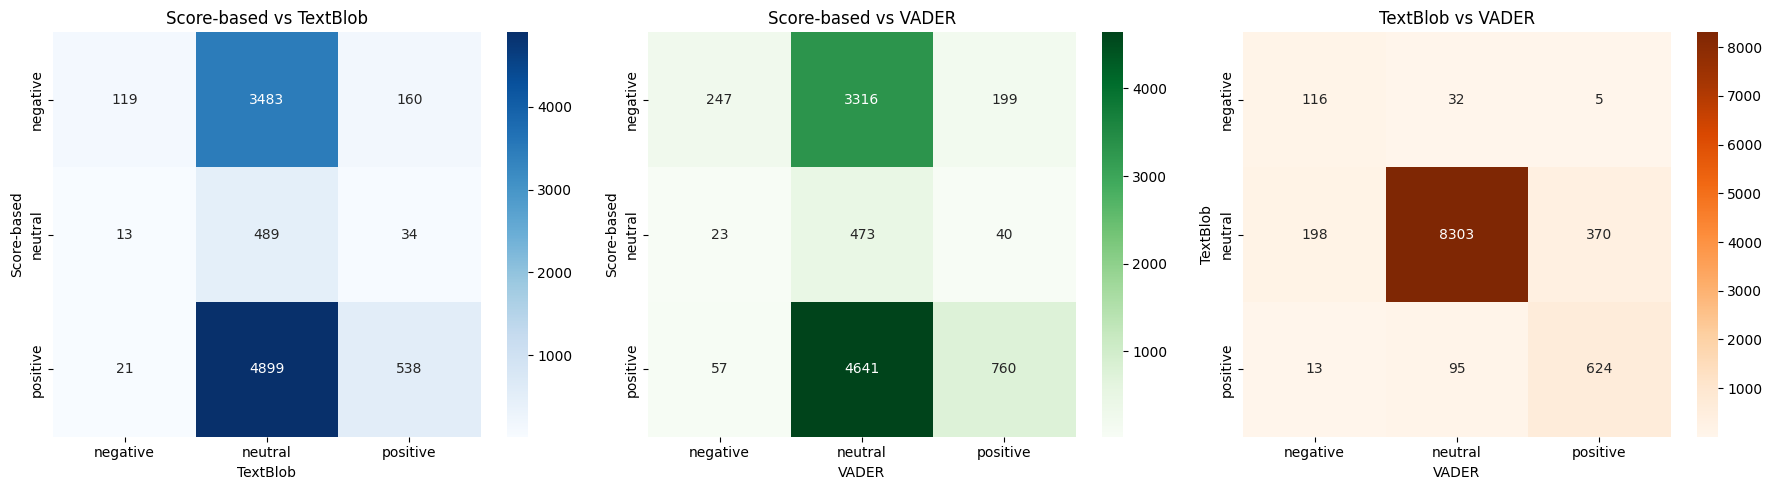

In [22]:
# Confusion matrix style comparison
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Score-based vs TextBlob
cm1 = confusion_matrix(df_clean['sentiment_score_based'], df_clean['sentiment_textblob'], 
                       labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'], ax=axes[0])
axes[0].set_title('Score-based vs TextBlob')
axes[0].set_xlabel('TextBlob')
axes[0].set_ylabel('Score-based')

# Score-based vs VADER
cm2 = confusion_matrix(df_clean['sentiment_score_based'], df_clean['sentiment_vader'], 
                       labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'], ax=axes[1])
axes[1].set_title('Score-based vs VADER')
axes[1].set_xlabel('VADER')
axes[1].set_ylabel('Score-based')

# TextBlob vs VADER
cm3 = confusion_matrix(df_clean['sentiment_textblob'], df_clean['sentiment_vader'], 
                       labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'], ax=axes[2])
axes[2].set_title('TextBlob vs VADER')
axes[2].set_xlabel('VADER')
axes[2].set_ylabel('TextBlob')

plt.tight_layout()
plt.show()

In [23]:
# Sample analysis - show examples of each sentiment
print("Sample reviews for each sentiment (Ensemble method):")
print("\n" + "="*80)

for sentiment in ['positive', 'neutral', 'negative']:
    print(f"\n{sentiment.upper()} SENTIMENT EXAMPLES:")
    print("-" * 50)
    
    samples = df_clean[df_clean['sentiment_ensemble'] == sentiment].head(3)
    
    for idx, row in samples.iterrows():
        print(f"\nScore: {row['score']} | Original: {row['content'][:100]}...")
        print(f"Stemmed: {row['stemmed_text']}")
        print(f"Methods: Score={row['sentiment_score_based']}, TextBlob={row['sentiment_textblob']}, VADER={row['sentiment_vader']}, Ensemble={row['sentiment_ensemble']}")
        print(f"TextBlob polarity: {row['textblob_polarity']:.3f}, VADER compound: {row['vader_compound']:.3f}")
        print("-" * 50)

Sample reviews for each sentiment (Ensemble method):


POSITIVE SENTIMENT EXAMPLES:
--------------------------------------------------

Score: 5 | Original: okay.....sippp......
Stemmed: okay sip
Methods: Score=positive, TextBlob=positive, VADER=positive, Ensemble=positive
TextBlob polarity: 0.500, VADER compound: 0.226
--------------------------------------------------

Score: 5 | Original: good joob...
Stemmed: good joob
Methods: Score=positive, TextBlob=positive, VADER=positive, Ensemble=positive
TextBlob polarity: 0.700, VADER compound: 0.440
--------------------------------------------------

Score: 5 | Original: terbaik banyak bonusnya...
Stemmed: baik banyak bonus
Methods: Score=positive, TextBlob=neutral, VADER=positive, Ensemble=positive
TextBlob polarity: 0.000, VADER compound: 0.542
--------------------------------------------------

NEUTRAL SENTIMENT EXAMPLES:
--------------------------------------------------

Score: 5 | Original: sangat mudah digunakan untuk melakukan ses

In [24]:
# Save results to new CSV file
output_columns = [
    'reviewId', 'content', 'score', 'stemmed_text',
    'sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble',
    'textblob_polarity', 'vader_compound'
]

# Select only the columns we want to save
df_output = df_clean[output_columns].copy()

# Save to new CSV file
output_filename = 'google_play_reviews_DigitalBank_sentiment_analysis.csv'
df_output.to_csv(output_filename, index=False)

print(f"Results saved to: {output_filename}")
print(f"Output dataset shape: {df_output.shape}")
print(f"\nColumns in output file: {list(df_output.columns)}")

Results saved to: google_play_reviews_DigitalBank_sentiment_analysis.csv
Output dataset shape: (9756, 10)

Columns in output file: ['reviewId', 'content', 'score', 'stemmed_text', 'sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble', 'textblob_polarity', 'vader_compound']


In [25]:
# Final summary statistics
print("FINAL SENTIMENT ANALYSIS SUMMARY")
print("=" * 50)

print(f"\nTotal reviews analyzed: {len(df_clean):,}")

print("\nSentiment distribution by method:")
for method in ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']:
    method_name = method.replace('sentiment_', '').replace('_', ' ').title()
    print(f"\n{method_name}:")
    counts = df_clean[method].value_counts()
    for sentiment, count in counts.items():
        percentage = (count / len(df_clean)) * 100
        print(f"  {sentiment}: {count:,} ({percentage:.1f}%)")

print("\nMethod agreement rates:")
print(f"Score-based vs TextBlob: {agreement_1:.1%}")
print(f"Score-based vs VADER: {agreement_2:.1%}")
print(f"TextBlob vs VADER: {agreement_3:.1%}")
print(f"All three methods: {all_agree:.1%}")

print(f"\nOutput file saved: {output_filename}")

FINAL SENTIMENT ANALYSIS SUMMARY

Total reviews analyzed: 9,756

Sentiment distribution by method:

Score Based:
  positive: 5,458 (55.9%)
  negative: 3,762 (38.6%)
  neutral: 536 (5.5%)

Textblob:
  neutral: 8,871 (90.9%)
  positive: 732 (7.5%)
  negative: 153 (1.6%)

Vader:
  neutral: 8,430 (86.4%)
  positive: 999 (10.2%)
  negative: 327 (3.4%)

Ensemble:
  neutral: 8,355 (85.6%)
  positive: 966 (9.9%)
  negative: 435 (4.5%)

Method agreement rates:
Score-based vs TextBlob: 11.7%
Score-based vs VADER: 15.2%
TextBlob vs VADER: 92.7%
All three methods: 10.8%

Output file saved: google_play_reviews_DigitalBank_sentiment_analysis.csv


## Advanced Visualizations and Detailed Comparisons

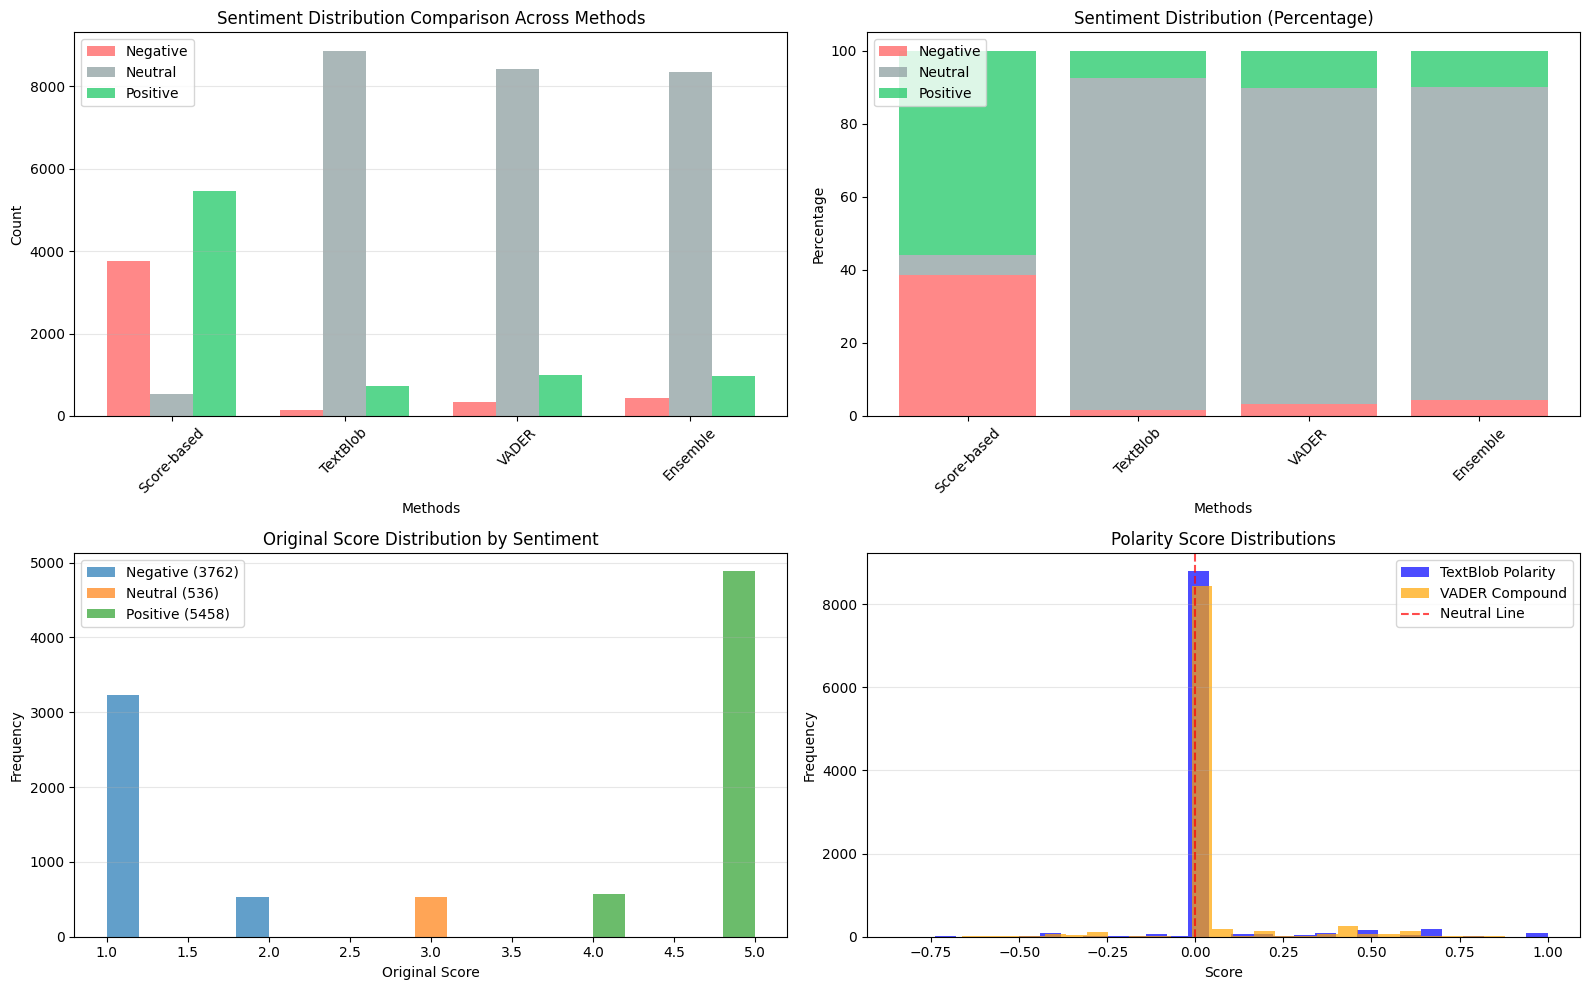

In [26]:
# 1. Comprehensive Bar Chart Comparison
plt.figure(figsize=(16, 10))

# Create comparison data
methods = ['Score-based', 'TextBlob', 'VADER', 'Ensemble']
sentiment_cols = ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']

# Get counts for each method
positive_counts = []
neutral_counts = []
negative_counts = []

for col in sentiment_cols:
    counts = df_clean[col].value_counts()
    positive_counts.append(counts.get('positive', 0))
    neutral_counts.append(counts.get('neutral', 0))
    negative_counts.append(counts.get('negative', 0))

# Create grouped bar chart
x = np.arange(len(methods))
width = 0.25

plt.subplot(2, 2, 1)
plt.bar(x - width, negative_counts, width, label='Negative', color='#ff6b6b', alpha=0.8)
plt.bar(x, neutral_counts, width, label='Neutral', color='#95a5a6', alpha=0.8)
plt.bar(x + width, positive_counts, width, label='Positive', color='#2ecc71', alpha=0.8)

plt.xlabel('Methods')
plt.ylabel('Count')
plt.title('Sentiment Distribution Comparison Across Methods')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. Percentage Stacked Bar Chart
plt.subplot(2, 2, 2)
total_counts = [sum([pos, neu, neg]) for pos, neu, neg in zip(positive_counts, neutral_counts, negative_counts)]
positive_pct = [pos/total*100 for pos, total in zip(positive_counts, total_counts)]
neutral_pct = [neu/total*100 for neu, total in zip(neutral_counts, total_counts)]
negative_pct = [neg/total*100 for neg, total in zip(negative_counts, total_counts)]

plt.bar(methods, negative_pct, label='Negative', color='#ff6b6b', alpha=0.8)
plt.bar(methods, neutral_pct, bottom=negative_pct, label='Neutral', color='#95a5a6', alpha=0.8)
plt.bar(methods, positive_pct, bottom=[neg+neu for neg, neu in zip(negative_pct, neutral_pct)], 
        label='Positive', color='#2ecc71', alpha=0.8)

plt.xlabel('Methods')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution (Percentage)')
plt.xticks(rotation=45)
plt.legend()

# 3. Score Distribution by Sentiment (Score-based method)
plt.subplot(2, 2, 3)
for sentiment in ['negative', 'neutral', 'positive']:
    scores = df_clean[df_clean['sentiment_score_based'] == sentiment]['score']
    plt.hist(scores, alpha=0.7, label=f'{sentiment.title()} ({len(scores)})', bins=5)

plt.xlabel('Original Score')
plt.ylabel('Frequency')
plt.title('Original Score Distribution by Sentiment')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 4. Polarity Score Distributions
plt.subplot(2, 2, 4)
plt.hist(df_clean['textblob_polarity'], alpha=0.7, bins=30, label='TextBlob Polarity', color='blue')
plt.hist(df_clean['vader_compound'], alpha=0.7, bins=30, label='VADER Compound', color='orange')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral Line')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Polarity Score Distributions')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

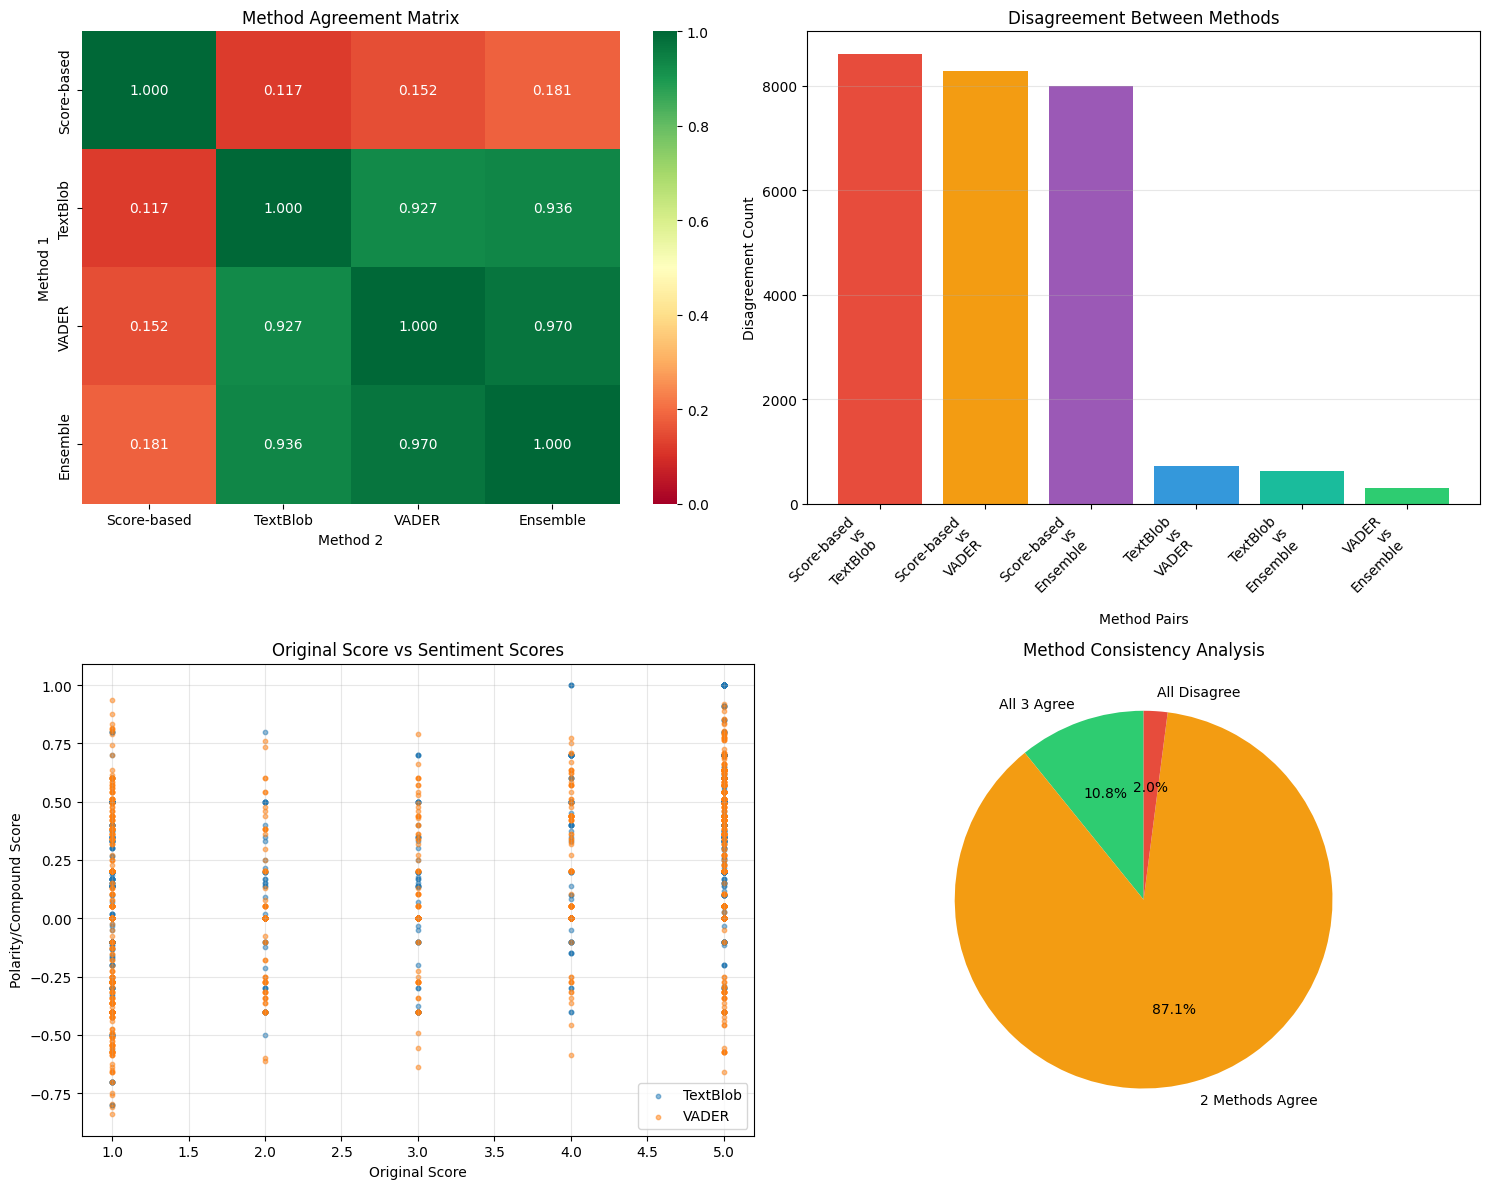

In [27]:
# 2. Agreement Matrix Visualization
plt.figure(figsize=(15, 12))

# Calculate agreement matrix
methods = ['Score-based', 'TextBlob', 'VADER', 'Ensemble']
sentiment_cols = ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']

agreement_matrix = np.zeros((4, 4))
for i, col1 in enumerate(sentiment_cols):
    for j, col2 in enumerate(sentiment_cols):
        if i == j:
            agreement_matrix[i][j] = 1.0  # Perfect agreement with itself
        else:
            agreement = (df_clean[col1] == df_clean[col2]).mean()
            agreement_matrix[i][j] = agreement

# Plot agreement heatmap
plt.subplot(2, 2, 1)
sns.heatmap(agreement_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=methods, yticklabels=methods, vmin=0, vmax=1)
plt.title('Method Agreement Matrix')
plt.ylabel('Method 1')
plt.xlabel('Method 2')

# Disagreement analysis
plt.subplot(2, 2, 2)
disagreement_counts = []
method_pairs = []

for i in range(len(sentiment_cols)):
    for j in range(i+1, len(sentiment_cols)):
        disagreement = (df_clean[sentiment_cols[i]] != df_clean[sentiment_cols[j]]).sum()
        disagreement_counts.append(disagreement)
        method_pairs.append(f'{methods[i]}\nvs\n{methods[j]}')

plt.bar(range(len(disagreement_counts)), disagreement_counts, 
        color=['#e74c3c', '#f39c12', '#9b59b6', '#3498db', '#1abc9c', '#2ecc71'])
plt.xlabel('Method Pairs')
plt.ylabel('Disagreement Count')
plt.title('Disagreement Between Methods')
plt.xticks(range(len(method_pairs)), method_pairs, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Score vs Polarity correlation
plt.subplot(2, 2, 3)
plt.scatter(df_clean['score'], df_clean['textblob_polarity'], alpha=0.5, s=10, label='TextBlob')
plt.scatter(df_clean['score'], df_clean['vader_compound'], alpha=0.5, s=10, label='VADER')
plt.xlabel('Original Score')
plt.ylabel('Polarity/Compound Score')
plt.title('Original Score vs Sentiment Scores')
plt.legend()
plt.grid(alpha=0.3)

# Method consistency analysis
plt.subplot(2, 2, 4)
consistency_data = []
labels = []

# All methods agree
all_agree_count = ((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
                   (df_clean['sentiment_textblob'] == df_clean['sentiment_vader'])).sum()
consistency_data.append(all_agree_count)
labels.append('All 3 Agree')

# Two methods agree
two_agree_count = (((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
                    (df_clean['sentiment_textblob'] != df_clean['sentiment_vader'])) |
                   ((df_clean['sentiment_score_based'] == df_clean['sentiment_vader']) & 
                    (df_clean['sentiment_score_based'] != df_clean['sentiment_textblob'])) |
                   ((df_clean['sentiment_textblob'] == df_clean['sentiment_vader']) & 
                    (df_clean['sentiment_textblob'] != df_clean['sentiment_score_based']))).sum()
consistency_data.append(two_agree_count)
labels.append('2 Methods Agree')

# All disagree
all_disagree_count = ((df_clean['sentiment_score_based'] != df_clean['sentiment_textblob']) & 
                      (df_clean['sentiment_textblob'] != df_clean['sentiment_vader']) & 
                      (df_clean['sentiment_score_based'] != df_clean['sentiment_vader'])).sum()
consistency_data.append(all_disagree_count)
labels.append('All Disagree')

colors = ['#2ecc71', '#f39c12', '#e74c3c']
plt.pie(consistency_data, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Method Consistency Analysis')

plt.tight_layout()
plt.show()

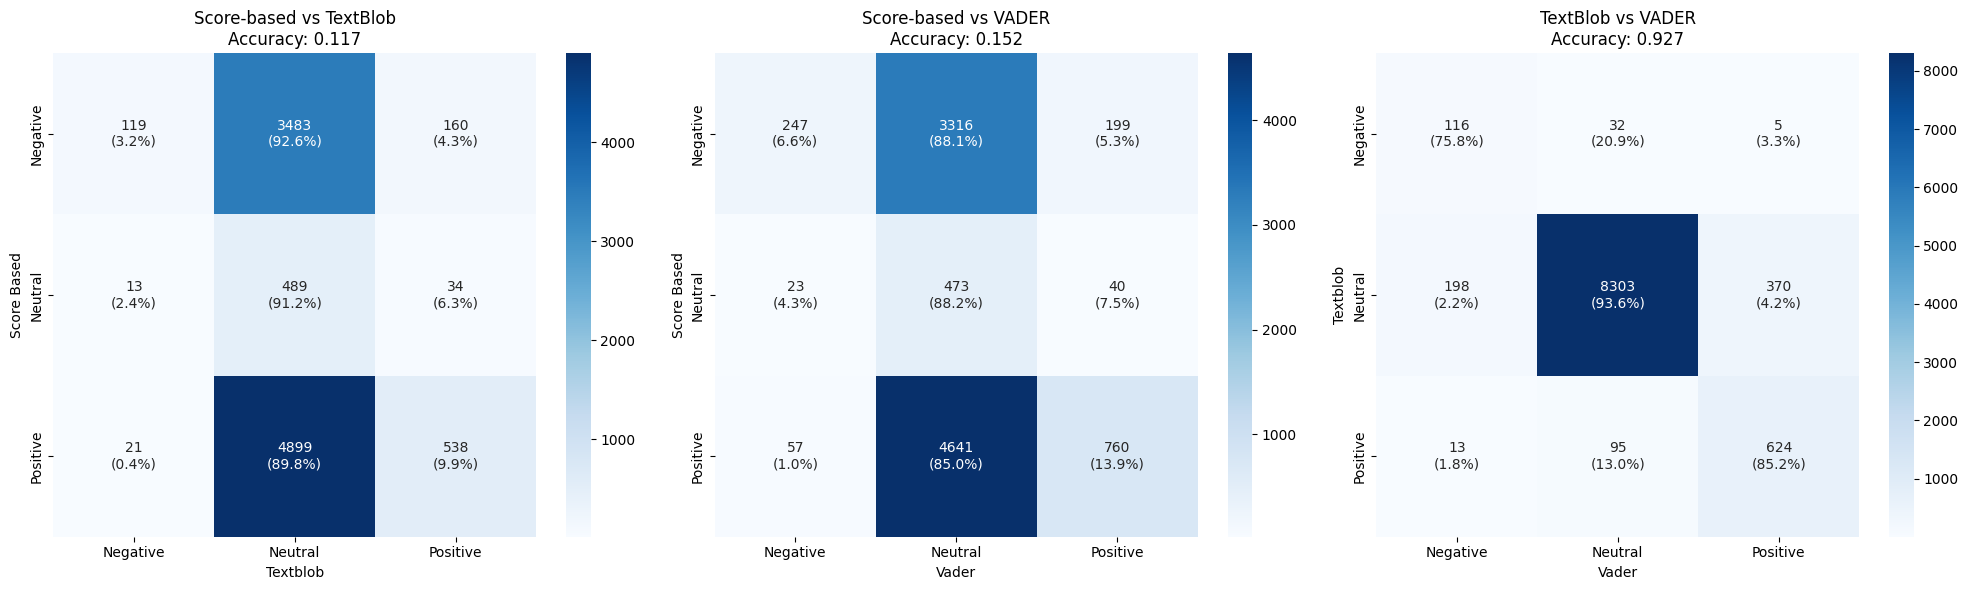


DETAILED CLASSIFICATION REPORTS

Score-based vs TextBlob:
--------------------------------------------------
Accuracy: 0.117
Cohen's Kappa: 0.022
Kappa Interpretation: Slight agreement

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.03      0.06      3762
     neutral       0.06      0.91      0.10       536
    positive       0.73      0.10      0.17      5458

    accuracy                           0.12      9756
   macro avg       0.52      0.35      0.11      9756
weighted avg       0.71      0.12      0.13      9756


Score-based vs VADER:
--------------------------------------------------
Accuracy: 0.152
Cohen's Kappa: 0.039
Kappa Interpretation: Slight agreement

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.07      0.12      3762
     neutral       0.06      0.88      0.11       536
    positive       0.76      0.14      0.24      5458

    accuracy     

In [28]:
# 3. Detailed Confusion Matrices with Statistics
from sklearn.metrics import classification_report, cohen_kappa_score

plt.figure(figsize=(20, 6))

# Define method pairs for comparison
comparisons = [
    ('sentiment_score_based', 'sentiment_textblob', 'Score-based vs TextBlob'),
    ('sentiment_score_based', 'sentiment_vader', 'Score-based vs VADER'),
    ('sentiment_textblob', 'sentiment_vader', 'TextBlob vs VADER')
]

for idx, (method1, method2, title) in enumerate(comparisons):
    plt.subplot(1, 3, idx + 1)
    
    # Create confusion matrix
    cm = confusion_matrix(df_clean[method1], df_clean[method2], 
                         labels=['negative', 'neutral', 'positive'])
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations with both count and percentage
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            row.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
        annotations.append(row)
    
    # Plot heatmap
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    
    plt.title(f'{title}\nAccuracy: {(df_clean[method1] == df_clean[method2]).mean():.3f}')
    plt.xlabel(method2.replace('sentiment_', '').replace('_', ' ').title())
    plt.ylabel(method1.replace('sentiment_', '').replace('_', ' ').title())

plt.tight_layout()
plt.show()

# Print detailed classification reports
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for method1, method2, title in comparisons:
    print(f"\n{title}:")
    print("-" * 50)
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(df_clean[method1], df_clean[method2])
    accuracy = (df_clean[method1] == df_clean[method2]).mean()
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Cohen's Kappa: {kappa:.3f}")
    
    # Interpretation of Kappa
    if kappa < 0:
        kappa_interpretation = "Poor agreement"
    elif kappa < 0.20:
        kappa_interpretation = "Slight agreement"
    elif kappa < 0.40:
        kappa_interpretation = "Fair agreement"
    elif kappa < 0.60:
        kappa_interpretation = "Moderate agreement"
    elif kappa < 0.80:
        kappa_interpretation = "Substantial agreement"
    else:
        kappa_interpretation = "Almost perfect agreement"
    
    print(f"Kappa Interpretation: {kappa_interpretation}")
    
    print("\nClassification Report:")
    print(classification_report(df_clean[method1], df_clean[method2], 
                              target_names=['negative', 'neutral', 'positive']))

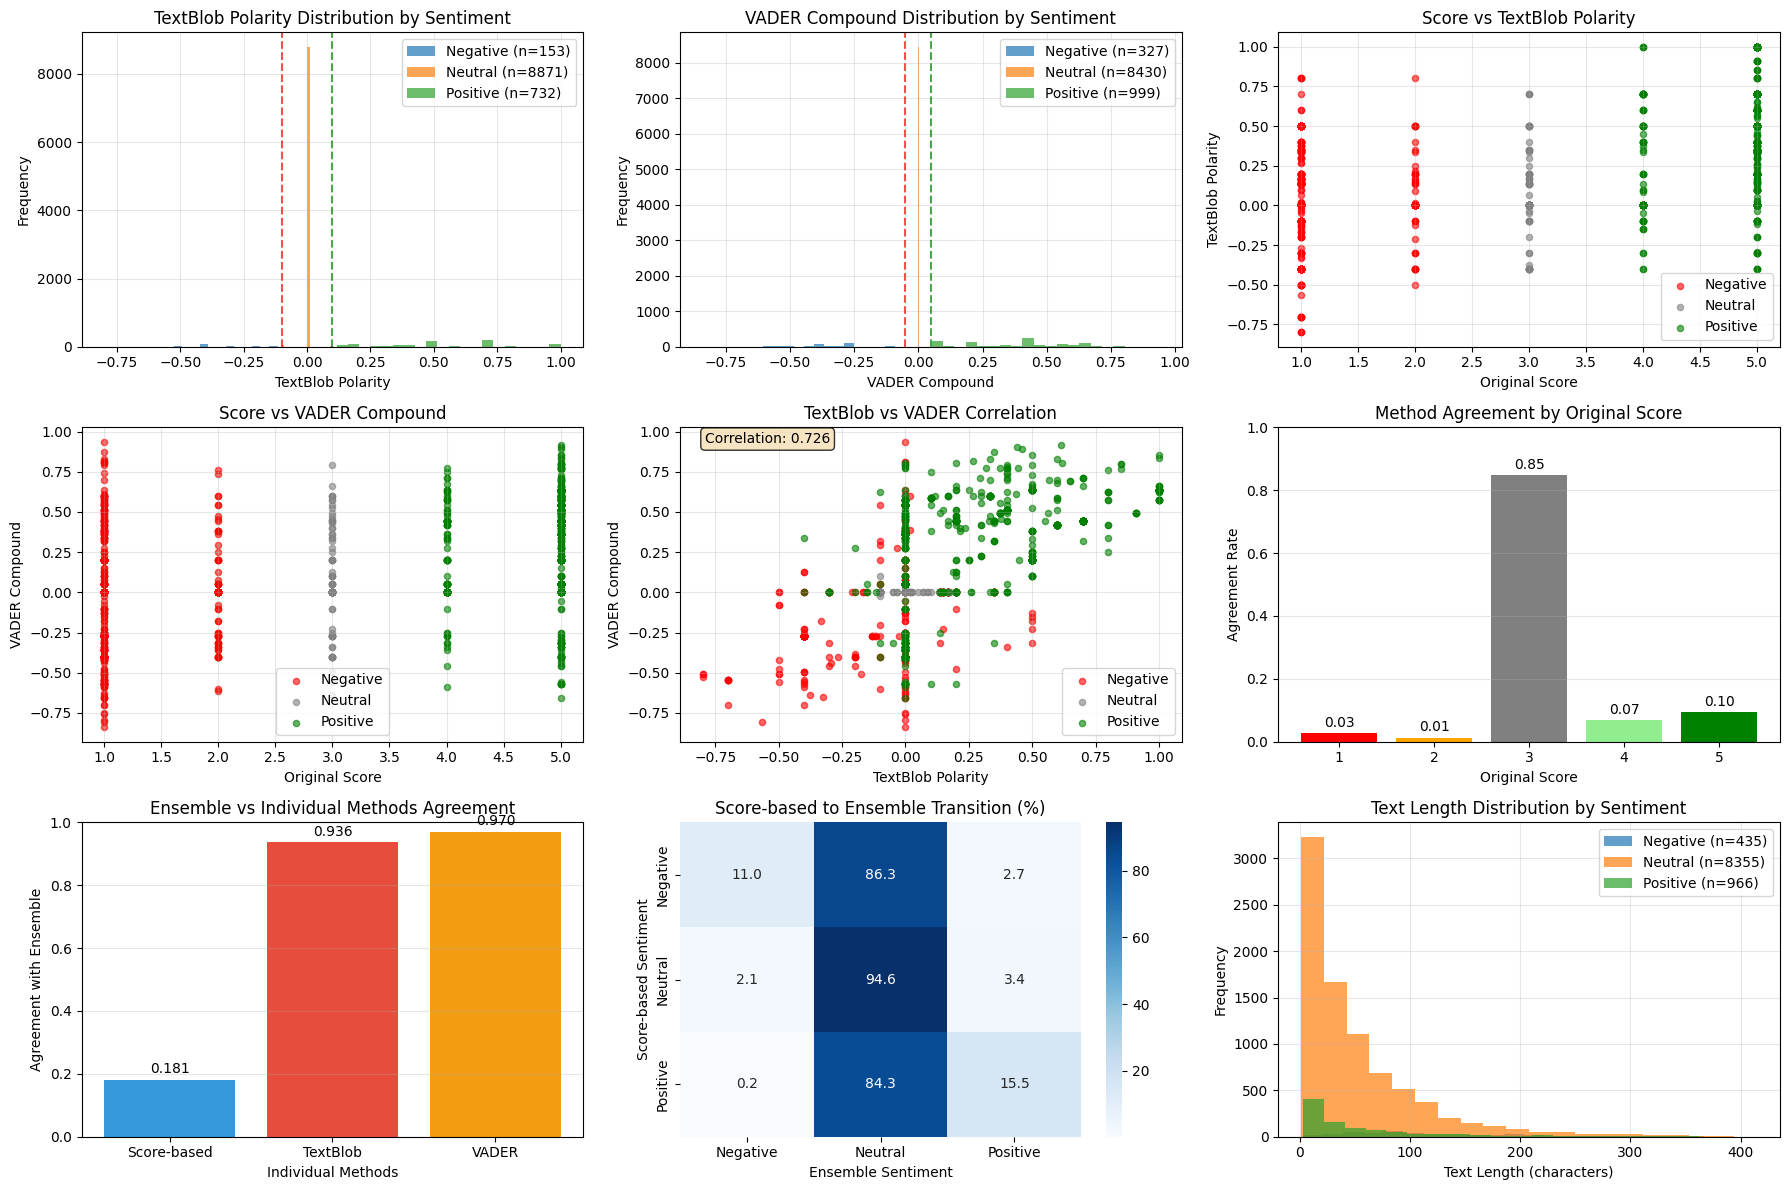

In [29]:
# 4. Sentiment Score Analysis and Distributions
plt.figure(figsize=(18, 12))

# 1. TextBlob Polarity by Sentiment Category
plt.subplot(3, 3, 1)
for sentiment in ['negative', 'neutral', 'positive']:
    data = df_clean[df_clean['sentiment_textblob'] == sentiment]['textblob_polarity']
    plt.hist(data, alpha=0.7, label=f'{sentiment.title()} (n={len(data)})', bins=20)
plt.xlabel('TextBlob Polarity')
plt.ylabel('Frequency')
plt.title('TextBlob Polarity Distribution by Sentiment')
plt.legend()
plt.axvline(x=0.1, color='green', linestyle='--', alpha=0.7, label='Positive threshold')
plt.axvline(x=-0.1, color='red', linestyle='--', alpha=0.7, label='Negative threshold')
plt.grid(alpha=0.3)

# 2. VADER Compound by Sentiment Category
plt.subplot(3, 3, 2)
for sentiment in ['negative', 'neutral', 'positive']:
    data = df_clean[df_clean['sentiment_vader'] == sentiment]['vader_compound']
    plt.hist(data, alpha=0.7, label=f'{sentiment.title()} (n={len(data)})', bins=20)
plt.xlabel('VADER Compound')
plt.ylabel('Frequency')
plt.title('VADER Compound Distribution by Sentiment')
plt.legend()
plt.axvline(x=0.05, color='green', linestyle='--', alpha=0.7, label='Positive threshold')
plt.axvline(x=-0.05, color='red', linestyle='--', alpha=0.7, label='Negative threshold')
plt.grid(alpha=0.3)

# 3. Score vs TextBlob Polarity Scatter
plt.subplot(3, 3, 3)
colors = {'negative': 'red', 'neutral': 'gray', 'positive': 'green'}
for sentiment in ['negative', 'neutral', 'positive']:
    mask = df_clean['sentiment_score_based'] == sentiment
    plt.scatter(df_clean[mask]['score'], df_clean[mask]['textblob_polarity'], 
               alpha=0.6, s=20, c=colors[sentiment], label=sentiment.title())
plt.xlabel('Original Score')
plt.ylabel('TextBlob Polarity')
plt.title('Score vs TextBlob Polarity')
plt.legend()
plt.grid(alpha=0.3)

# 4. Score vs VADER Compound Scatter
plt.subplot(3, 3, 4)
for sentiment in ['negative', 'neutral', 'positive']:
    mask = df_clean['sentiment_score_based'] == sentiment
    plt.scatter(df_clean[mask]['score'], df_clean[mask]['vader_compound'], 
               alpha=0.6, s=20, c=colors[sentiment], label=sentiment.title())
plt.xlabel('Original Score')
plt.ylabel('VADER Compound')
plt.title('Score vs VADER Compound')
plt.legend()
plt.grid(alpha=0.3)

# 5. TextBlob vs VADER Correlation
plt.subplot(3, 3, 5)
for sentiment in ['negative', 'neutral', 'positive']:
    mask = df_clean['sentiment_ensemble'] == sentiment
    plt.scatter(df_clean[mask]['textblob_polarity'], df_clean[mask]['vader_compound'], 
               alpha=0.6, s=20, c=colors[sentiment], label=sentiment.title())
plt.xlabel('TextBlob Polarity')
plt.ylabel('VADER Compound')
plt.title('TextBlob vs VADER Correlation')
plt.legend()
plt.grid(alpha=0.3)

# Calculate correlation
correlation = df_clean['textblob_polarity'].corr(df_clean['vader_compound'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 6. Method Agreement by Original Score
plt.subplot(3, 3, 6)
agreement_by_score = []
scores = sorted(df_clean['score'].unique())
for score in scores:
    subset = df_clean[df_clean['score'] == score]
    agreement = ((subset['sentiment_score_based'] == subset['sentiment_textblob']) & 
                (subset['sentiment_textblob'] == subset['sentiment_vader'])).mean()
    agreement_by_score.append(agreement)

plt.bar(scores, agreement_by_score, color=['red', 'orange', 'gray', 'lightgreen', 'green'])
plt.xlabel('Original Score')
plt.ylabel('Agreement Rate')
plt.title('Method Agreement by Original Score')
plt.ylim(0, 1)
for i, v in enumerate(agreement_by_score):
    plt.text(scores[i], v + 0.02, f'{v:.2f}', ha='center')
plt.grid(axis='y', alpha=0.3)

# 7. Ensemble vs Individual Methods Comparison
plt.subplot(3, 3, 7)
ensemble_vs_methods = []
method_names = ['Score-based', 'TextBlob', 'VADER']
method_cols = ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader']

for col in method_cols:
    agreement = (df_clean['sentiment_ensemble'] == df_clean[col]).mean()
    ensemble_vs_methods.append(agreement)

plt.bar(method_names, ensemble_vs_methods, color=['#3498db', '#e74c3c', '#f39c12'])
plt.xlabel('Individual Methods')
plt.ylabel('Agreement with Ensemble')
plt.title('Ensemble vs Individual Methods Agreement')
plt.ylim(0, 1)
for i, v in enumerate(ensemble_vs_methods):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
plt.grid(axis='y', alpha=0.3)

# 8. Sentiment Transition Matrix (Score-based to Ensemble)
plt.subplot(3, 3, 8)
transition_matrix = pd.crosstab(df_clean['sentiment_score_based'], df_clean['sentiment_ensemble'], 
                               normalize='index') * 100
sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Score-based to Ensemble Transition (%)')
plt.xlabel('Ensemble Sentiment')
plt.ylabel('Score-based Sentiment')

# 9. Text Length vs Sentiment Analysis
plt.subplot(3, 3, 9)
df_clean['text_length'] = df_clean['stemmed_text'].str.len()
for sentiment in ['negative', 'neutral', 'positive']:
    data = df_clean[df_clean['sentiment_ensemble'] == sentiment]['text_length']
    plt.hist(data, alpha=0.7, label=f'{sentiment.title()} (n={len(data)})', bins=20)
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Text Length Distribution by Sentiment')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# 5. Advanced Statistical Analysis
print("\n" + "="*80)
print("ADVANCED STATISTICAL ANALYSIS")
print("="*80)

# 1. Correlation Analysis
print("\n1. CORRELATION ANALYSIS:")
print("-" * 40)
correlation_data = df_clean[['score', 'textblob_polarity', 'vader_compound']]
correlation_matrix = correlation_data.corr()
print(correlation_matrix)

# 2. Statistical Tests
from scipy.stats import chi2_contingency, pearsonr

print("\n2. CHI-SQUARE TESTS FOR INDEPENDENCE:")
print("-" * 40)

# Test independence between methods
for method1, method2, title in [('sentiment_score_based', 'sentiment_textblob', 'Score-based vs TextBlob'),
                               ('sentiment_score_based', 'sentiment_vader', 'Score-based vs VADER'),
                               ('sentiment_textblob', 'sentiment_vader', 'TextBlob vs VADER')]:
    
    contingency_table = pd.crosstab(df_clean[method1], df_clean[method2])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n{title}:")
    print(f"  Chi-square statistic: {chi2:.3f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print(f"  Result: Methods are significantly dependent (p < 0.05)")
    else:
        print(f"  Result: Methods are independent (p >= 0.05)")

# 3. Pearson Correlations
print("\n3. PEARSON CORRELATIONS:")
print("-" * 40)

correlations = [
    ('score', 'textblob_polarity', 'Original Score vs TextBlob Polarity'),
    ('score', 'vader_compound', 'Original Score vs VADER Compound'),
    ('textblob_polarity', 'vader_compound', 'TextBlob vs VADER')
]

for var1, var2, title in correlations:
    corr, p_value = pearsonr(df_clean[var1], df_clean[var2])
    print(f"\n{title}:")
    print(f"  Correlation coefficient: {corr:.3f}")
    print(f"  p-value: {p_value:.6f}")
    
    # Interpretation
    if abs(corr) < 0.1:
        strength = "negligible"
    elif abs(corr) < 0.3:
        strength = "weak"
    elif abs(corr) < 0.5:
        strength = "moderate"
    elif abs(corr) < 0.7:
        strength = "strong"
    else:
        strength = "very strong"
    
    direction = "positive" if corr > 0 else "negative"
    print(f"  Interpretation: {strength.title()} {direction} correlation")

# 4. Method Performance Summary
print("\n4. METHOD PERFORMANCE SUMMARY:")
print("-" * 40)

performance_summary = pd.DataFrame({
    'Method': ['Score-based', 'TextBlob', 'VADER', 'Ensemble'],
    'Positive_Count': [df_clean['sentiment_score_based'].value_counts().get('positive', 0),
                      df_clean['sentiment_textblob'].value_counts().get('positive', 0),
                      df_clean['sentiment_vader'].value_counts().get('positive', 0),
                      df_clean['sentiment_ensemble'].value_counts().get('positive', 0)],
    'Neutral_Count': [df_clean['sentiment_score_based'].value_counts().get('neutral', 0),
                     df_clean['sentiment_textblob'].value_counts().get('neutral', 0),
                     df_clean['sentiment_vader'].value_counts().get('neutral', 0),
                     df_clean['sentiment_ensemble'].value_counts().get('neutral', 0)],
    'Negative_Count': [df_clean['sentiment_score_based'].value_counts().get('negative', 0),
                      df_clean['sentiment_textblob'].value_counts().get('negative', 0),
                      df_clean['sentiment_vader'].value_counts().get('negative', 0),
                      df_clean['sentiment_ensemble'].value_counts().get('negative', 0)]
})

# Calculate percentages
total = len(df_clean)
performance_summary['Positive_Pct'] = (performance_summary['Positive_Count'] / total * 100).round(1)
performance_summary['Neutral_Pct'] = (performance_summary['Neutral_Count'] / total * 100).round(1)
performance_summary['Negative_Pct'] = (performance_summary['Negative_Count'] / total * 100).round(1)

print(performance_summary)

# 5. Agreement Statistics Summary
print("\n5. AGREEMENT STATISTICS SUMMARY:")
print("-" * 40)

agreement_stats = {
    'Score-based vs TextBlob': (df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']).mean(),
    'Score-based vs VADER': (df_clean['sentiment_score_based'] == df_clean['sentiment_vader']).mean(),
    'TextBlob vs VADER': (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']).mean(),
    'All three methods': ((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
                         (df_clean['sentiment_textblob'] == df_clean['sentiment_vader'])).mean(),
    'Ensemble vs Score-based': (df_clean['sentiment_ensemble'] == df_clean['sentiment_score_based']).mean(),
    'Ensemble vs TextBlob': (df_clean['sentiment_ensemble'] == df_clean['sentiment_textblob']).mean(),
    'Ensemble vs VADER': (df_clean['sentiment_ensemble'] == df_clean['sentiment_vader']).mean()
}

for comparison, agreement in agreement_stats.items():
    print(f"{comparison}: {agreement:.3f} ({agreement*100:.1f}%)")


ADVANCED STATISTICAL ANALYSIS

1. CORRELATION ANALYSIS:
----------------------------------------
                      score  textblob_polarity  vader_compound
score              1.000000           0.168711        0.179759
textblob_polarity  0.168711           1.000000        0.725724
vader_compound     0.179759           0.725724        1.000000

2. CHI-SQUARE TESTS FOR INDEPENDENCE:
----------------------------------------

Score-based vs TextBlob:
  Chi-square statistic: 208.474
  p-value: 0.000000
  Degrees of freedom: 4
  Result: Methods are significantly dependent (p < 0.05)

Score-based vs VADER:
  Chi-square statistic: 373.189
  p-value: 0.000000
  Degrees of freedom: 4
  Result: Methods are significantly dependent (p < 0.05)

TextBlob vs VADER:
  Chi-square statistic: 7369.480
  p-value: 0.000000
  Degrees of freedom: 4
  Result: Methods are significantly dependent (p < 0.05)

3. PEARSON CORRELATIONS:
----------------------------------------

Original Score vs TextBlob Polari

In [31]:
# 6. Detailed Examples Analysis
print("\n" + "="*80)
print("DETAILED EXAMPLES ANALYSIS")
print("="*80)

# Find interesting cases where methods disagree
print("\n1. CASES WHERE ALL METHODS DISAGREE:")
print("-" * 50)

all_disagree_mask = ((df_clean['sentiment_score_based'] != df_clean['sentiment_textblob']) & 
                     (df_clean['sentiment_textblob'] != df_clean['sentiment_vader']) & 
                     (df_clean['sentiment_score_based'] != df_clean['sentiment_vader']))

all_disagree_examples = df_clean[all_disagree_mask].head(5)

for idx, row in all_disagree_examples.iterrows():
    print(f"\nExample {idx}:")
    print(f"Original Text: {row['content'][:150]}...")
    print(f"Stemmed Text: {row['stemmed_text']}")
    print(f"Original Score: {row['score']}")
    print(f"Score-based: {row['sentiment_score_based']}")
    print(f"TextBlob: {row['sentiment_textblob']} (polarity: {row['textblob_polarity']:.3f})")
    print(f"VADER: {row['sentiment_vader']} (compound: {row['vader_compound']:.3f})")
    print(f"Ensemble: {row['sentiment_ensemble']}")
    print("-" * 50)

print(f"\nTotal cases where all methods disagree: {all_disagree_mask.sum()} ({all_disagree_mask.mean()*100:.1f}%)")

# Cases where score-based disagrees with both TextBlob and VADER
print("\n2. CASES WHERE SCORE-BASED DISAGREES WITH BOTH TEXTBLOB AND VADER:")
print("-" * 50)

score_disagree_mask = ((df_clean['sentiment_score_based'] != df_clean['sentiment_textblob']) & 
                       (df_clean['sentiment_score_based'] != df_clean['sentiment_vader']) &
                       (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']))

score_disagree_examples = df_clean[score_disagree_mask].head(3)

for idx, row in score_disagree_examples.iterrows():
    print(f"\nExample {idx}:")
    print(f"Original Text: {row['content'][:150]}...")
    print(f"Stemmed Text: {row['stemmed_text']}")
    print(f"Original Score: {row['score']} → Score-based: {row['sentiment_score_based']}")
    print(f"TextBlob & VADER agree: {row['sentiment_textblob']}")
    print(f"TextBlob polarity: {row['textblob_polarity']:.3f}, VADER compound: {row['vader_compound']:.3f}")
    print(f"Ensemble decision: {row['sentiment_ensemble']}")
    print("-" * 50)

print(f"\nTotal cases: {score_disagree_mask.sum()} ({score_disagree_mask.mean()*100:.1f}%)")

# Perfect agreement cases
print("\n3. CASES WHERE ALL METHODS AGREE:")
print("-" * 50)

all_agree_mask = ((df_clean['sentiment_score_based'] == df_clean['sentiment_textblob']) & 
                  (df_clean['sentiment_textblob'] == df_clean['sentiment_vader']))

# Show examples for each sentiment where all agree
for sentiment in ['positive', 'negative', 'neutral']:
    sentiment_agree_examples = df_clean[all_agree_mask & (df_clean['sentiment_ensemble'] == sentiment)].head(2)
    
    print(f"\n{sentiment.upper()} examples where all methods agree:")
    for idx, row in sentiment_agree_examples.iterrows():
        print(f"  Score: {row['score']} | Text: {row['stemmed_text'][:100]}...")
        print(f"  TextBlob: {row['textblob_polarity']:.3f}, VADER: {row['vader_compound']:.3f}")

print(f"\nTotal cases where all methods agree: {all_agree_mask.sum()} ({all_agree_mask.mean()*100:.1f}%)")


DETAILED EXAMPLES ANALYSIS

1. CASES WHERE ALL METHODS DISAGREE:
--------------------------------------------------

Example 710:
Original Text: tolong saya lupa jawaban ke amanan fase 2 bank jago saya udah kirim dari via whatup,facebook,dan gmail dan saya tlp kantanya gratis eeh pulsa kesedot ...
Stemmed Text: lupa jawab aman fase bank jago kirim via whatup facebook gmail tlp kanta gratis eeh pulsa sedot lah
Original Score: 2
Score-based: negative
TextBlob: neutral (polarity: 0.000)
VADER: positive (compound: 0.052)
Ensemble: negative
--------------------------------------------------

Example 714:
Original Text: bener2 super lemot, mau buka aplikasi, transfer, liat saldo,, duhhh ga bisa sat set gitu...
Stemmed Text: super lot mau buka aplikasi transfer liat saldo duh sat set gitu
Original Score: 2
Score-based: negative
TextBlob: neutral (polarity: 0.017)
VADER: positive (compound: 0.599)
Ensemble: negative
--------------------------------------------------

Example 720:
Original Tex

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

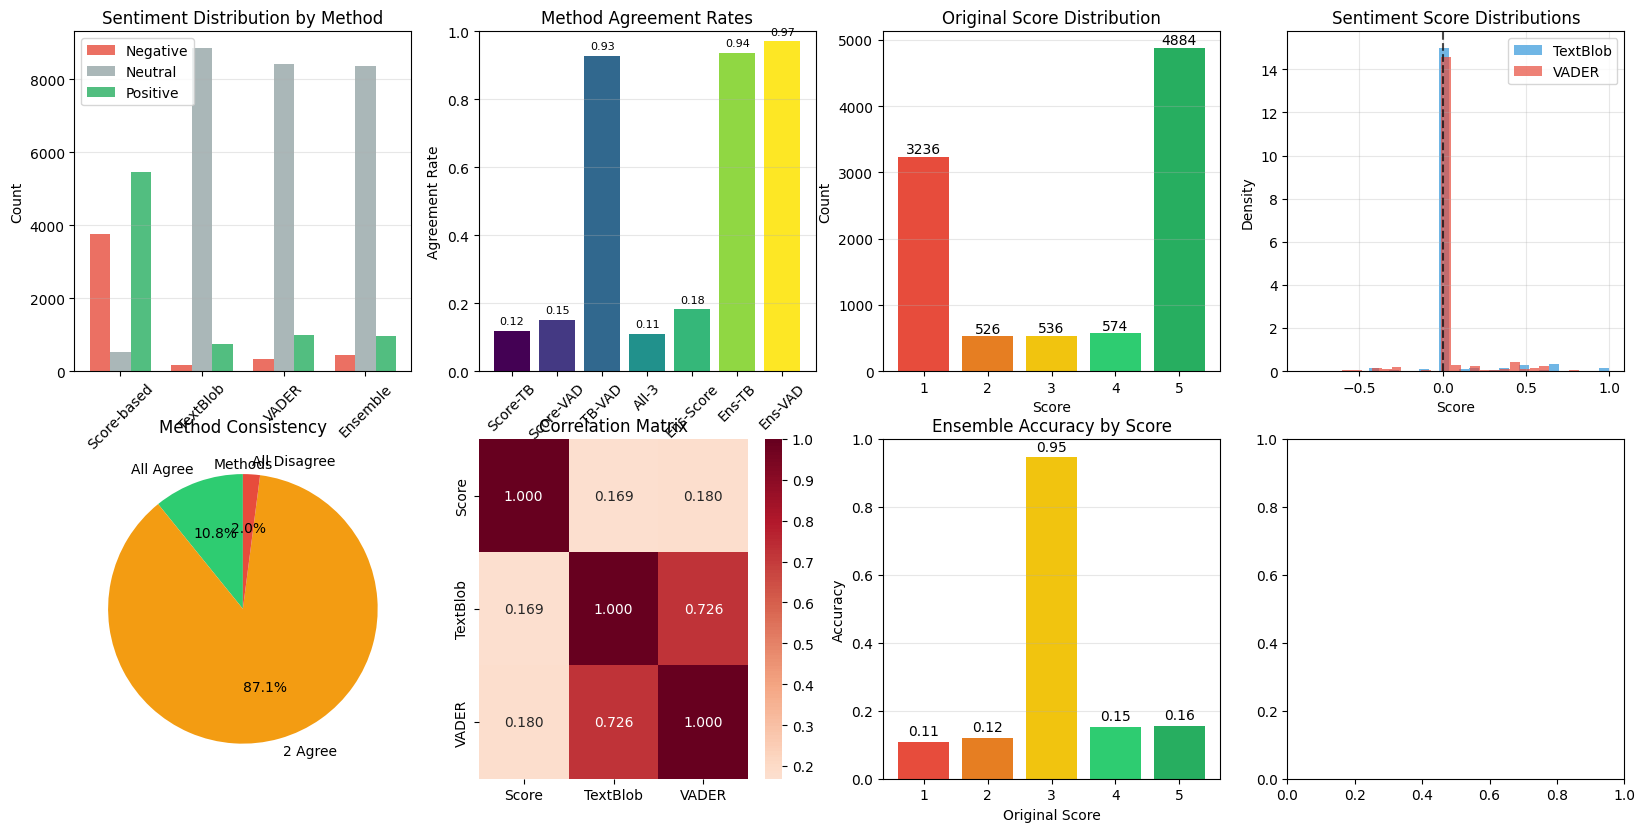

In [32]:
# 7. Final Comprehensive Summary Visualization
plt.figure(figsize=(20, 15))

# 1. Overall Method Comparison (Top Left)
plt.subplot(3, 4, 1)
methods = ['Score-based', 'TextBlob', 'VADER', 'Ensemble']
positive_counts = [df_clean[col].value_counts().get('positive', 0) for col in sentiment_columns]
neutral_counts = [df_clean[col].value_counts().get('neutral', 0) for col in sentiment_columns]
negative_counts = [df_clean[col].value_counts().get('negative', 0) for col in sentiment_columns]

x = np.arange(len(methods))
width = 0.25
plt.bar(x - width, negative_counts, width, label='Negative', color='#e74c3c', alpha=0.8)
plt.bar(x, neutral_counts, width, label='Neutral', color='#95a5a6', alpha=0.8)
plt.bar(x + width, positive_counts, width, label='Positive', color='#27ae60', alpha=0.8)
plt.title('Sentiment Distribution by Method')
plt.xlabel('Methods')
plt.ylabel('Count')
plt.xticks(x, methods, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. Agreement Rates (Top Right)
plt.subplot(3, 4, 2)
agreement_pairs = ['Score-TB', 'Score-VAD', 'TB-VAD', 'All-3', 'Ens-Score', 'Ens-TB', 'Ens-VAD']
agreement_values = list(agreement_stats.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(agreement_values)))
bars = plt.bar(range(len(agreement_pairs)), agreement_values, color=colors)
plt.title('Method Agreement Rates')
plt.xlabel('Method Pairs')
plt.ylabel('Agreement Rate')
plt.xticks(range(len(agreement_pairs)), agreement_pairs, rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(agreement_values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=8)
plt.grid(axis='y', alpha=0.3)

# 3. Score Distribution (Middle Left)
plt.subplot(3, 4, 3)
score_counts = df_clean['score'].value_counts().sort_index()
colors_score = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
plt.bar(score_counts.index, score_counts.values, color=colors_score)
plt.title('Original Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
for i, v in enumerate(score_counts.values):
    plt.text(score_counts.index[i], v + 50, str(v), ha='center')
plt.grid(axis='y', alpha=0.3)

# 4. Polarity Distributions (Middle Right)
plt.subplot(3, 4, 4)
plt.hist(df_clean['textblob_polarity'], alpha=0.7, bins=30, label='TextBlob', color='#3498db', density=True)
plt.hist(df_clean['vader_compound'], alpha=0.7, bins=30, label='VADER', color='#e74c3c', density=True)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.title('Sentiment Score Distributions')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)

# 5. Consistency Analysis (Bottom Left)
plt.subplot(3, 4, 5)
consistency_labels = ['All Agree', '2 Agree', 'All Disagree']
consistency_values = [
    all_agree_mask.sum(),
    two_agree_count,
    all_disagree_mask.sum()
]
colors_consistency = ['#2ecc71', '#f39c12', '#e74c3c']
plt.pie(consistency_values, labels=consistency_labels, autopct='%1.1f%%', 
        colors=colors_consistency, startangle=90)
plt.title('Method Consistency')

# 6. Correlation Heatmap (Bottom Middle)
plt.subplot(3, 4, 6)
corr_data = df_clean[['score', 'textblob_polarity', 'vader_compound']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            xticklabels=['Score', 'TextBlob', 'VADER'],
            yticklabels=['Score', 'TextBlob', 'VADER'])
plt.title('Correlation Matrix')

# 7. Method Performance by Score (Bottom Right)
plt.subplot(3, 4, 7)
scores = sorted(df_clean['score'].unique())
ensemble_accuracy_by_score = []
for score in scores:
    subset = df_clean[df_clean['score'] == score]
    # Calculate how often ensemble matches the expected sentiment for that score
    expected_sentiment = score_based_sentiment(score)
    accuracy = (subset['sentiment_ensemble'] == expected_sentiment).mean()
    ensemble_accuracy_by_score.append(accuracy)

plt.bar(scores, ensemble_accuracy_by_score, color=colors_score)
plt.title('Ensemble Accuracy by Score')
plt.xlabel('Original Score')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(ensemble_accuracy_by_score):
    plt.text(scores[i], v + 0.02, f'{v:.2f}', ha='center')
plt.grid(axis='y', alpha=0.3)

# 8. Text Length Analysis (Far Right)
plt.subplot(3, 4, 8)
for sentiment in ['negative', 'neutral', 'positive']:
    data = df_clean[df_clean['sentiment_ensemble'] == sentiment]['text_length']
    plt.boxplot([data], positions=[['negative', 'neutral', 'positive'].index(sentiment)], 
               patch_artist=True, boxprops=dict(facecolor=colors[sentiment]))

plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.grid(axis='y', alpha=0.3)

# Add overall statistics as text
plt.subplot(3, 4, 9)
plt.axis('off')
stats_text = f"""
SUMMARY STATISTICS
{'='*20}
Total Reviews: {len(df_clean):,}

Method Agreement:
• All 3 methods: {all_agree_mask.mean():.1%}
• Score-TextBlob: {agreement_1:.1%}
• Score-VADER: {agreement_2:.1%}
• TextBlob-VADER: {agreement_3:.1%}

Correlations:
• Score-TextBlob: {df_clean['score'].corr(df_clean['textblob_polarity']):.3f}
• Score-VADER: {df_clean['score'].corr(df_clean['vader_compound']):.3f}
• TextBlob-VADER: {df_clean['textblob_polarity'].corr(df_clean['vader_compound']):.3f}

Ensemble vs Individual:
• vs Score-based: {(df_clean['sentiment_ensemble'] == df_clean['sentiment_score_based']).mean():.1%}
• vs TextBlob: {(df_clean['sentiment_ensemble'] == df_clean['sentiment_textblob']).mean():.1%}
• vs VADER: {(df_clean['sentiment_ensemble'] == df_clean['sentiment_vader']).mean():.1%}
"""
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SENTIMENT ANALYSIS COMPLETE!")
print("="*80)
print(f"\nResults saved to: {output_filename}")
print(f"Total reviews processed: {len(df_clean):,}")
print(f"\nAll visualizations and comparisons have been generated.")
print(f"The notebook provides comprehensive analysis of sentiment labeling using 4 methods.")

In [ ]:
import os

# Create a Markdown report summarizing key outputs and graphics
report_filename = "sentiment_analysis_report.md"

with open(report_filename, "w", encoding="utf-8") as f:
    f.write("# Sentiment Analysis Report\n\n")
    f.write("This report summarizes the results and visualizations from the sentiment analysis notebook.\n\n")
    
    # Dataset summary
    f.write("## Dataset Summary\n")
    f.write(f"- Total reviews analyzed: **{len(df_clean):,}**\n")
    f.write(f"- Columns in dataset: {list(df_clean.columns)}\n\n")
    f.write("### Score Distribution\n")
    f.write("```\n")
    f.write(str(score_counts))
    f.write("\n```\n\n")
    
    # Sentiment distributions
    f.write("## Sentiment Distribution by Method\n")
    for method in ['sentiment_score_based', 'sentiment_textblob', 'sentiment_vader', 'sentiment_ensemble']:
        f.write(f"### {method.replace('sentiment_', '').replace('_', ' ').title()}\n")
        counts = df_clean[method].value_counts()
        for sentiment, count in counts.items():
            pct = (count / len(df_clean)) * 100
            f.write(f"- {sentiment}: {count:,} ({pct:.1f}%)\n")
        f.write("\n")
    
    # Performance summary table
    f.write("### Performance Summary Table\n")
    f.write(performance_summary.to_markdown(index=False))
    f.write("\n\n")
    
    # Agreement statistics
    f.write("## Agreement Statistics\n")
    for comparison, agreement in agreement_stats.items():
        f.write(f"- {comparison}: {agreement:.3f} ({agreement*100:.1f}%)\n")
    f.write("\n")
    
    # Correlation matrix
    f.write("## Correlation Matrix\n")
    f.write("```\n")
    f.write(str(df_clean[['score', 'textblob_polarity', 'vader_compound']].corr()))
    f.write("\n```\n\n")
    
    # Transition matrix
    f.write("## Score-based to Ensemble Transition Matrix (%)\n")
    f.write(transition_matrix.to_markdown())
    f.write("\n\n")
    
    # Add references to graphics (assuming they are saved as PNGs)
    f.write("## Visualizations\n")
    f.write("Below are the main graphics generated in the notebook. Please refer to the notebook for interactive versions.\n\n")
    graphics = [
        "sentiment_distribution_methods.png",
        "agreement_matrix.png",
        "score_vs_polarity.png",
        "method_consistency_pie.png",
        "confusion_matrices.png",
        "score_distribution_by_sentiment.png",
        "text_length_by_sentiment.png"
    ]
    for img in graphics:
        if os.path.exists(img):
            f.write(f"![{img}]({img})\n\n")
        else:
            f.write(f"- `{img}` (please export this plot from the notebook)\n")
    
    # Example outputs
    f.write("## Example Reviews\n")
    f.write("### Cases Where All Methods Disagree\n")
    for idx, row in all_disagree_examples.iterrows():
        f.write(f"- **Text:** {row['content'][:100]}...\n")
        f.write(f"  - Score: {row['score']}, Score-based: {row['sentiment_score_based']}, TextBlob: {row['sentiment_textblob']} ({row['textblob_polarity']:.3f}), VADER: {row['sentiment_vader']} ({row['vader_compound']:.3f}), Ensemble: {row['sentiment_ensemble']}\n")
    f.write("\n")
    
    f.write("### Cases Where All Methods Agree (Neutral Example)\n")
    for idx, row in sentiment_agree_examples.iterrows():
        f.write(f"- **Text:** {row['content'][:100]}...\n")
        f.write(f"  - Score: {row['score']}, All methods: {row['sentiment_ensemble']}\n")
    f.write("\n")
    
    f.write("> **Note:** For full details and interactive plots, see the original Jupyter notebook.\n")

print(f"Markdown report saved to: {report_filename}")

Markdown report saved to: sentiment_analysis_report.md
